# Mantenimiento Predictivo de Turbinas

Durante la vida útil de las turbinas, estas sufren desgaste, que impacta directamente en su confiabilidad y performance.
Esta notebook es para crear un modelo reutilizable, que en este caso es para predecir la vida util restante (RUL: remaining useful life) de turbinas, basado en data sobre el ciclo de vida completo de las mismas para planificar mejor su mantenimiento.

<img src='_src/turbofan-operation-lbp.png'>

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
import xgboost

from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# venv/Scripts/Activate.ps1

---

#### Definimos nombres de variables

In [2]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = [f's_{i+1}' for i in range(0, 21)]
col_names = index_names + setting_names + sensor_names

#### Importamos la data de entrenamiento y de validación.

El dataset FD001 corresponde a una falla HPC de la turbina.

In [3]:
dftrain = pd.read_csv('_data/train_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
dfvalid = pd.read_csv('_data/test_FD001.txt',sep='\s+',header=None,index_col=False,names=col_names)
y_valid = pd.read_csv('_data/RUL_FD001.txt',sep='\s+',header=None,index_col=False,names=['RUL'])
dfvalid.shape

(13096, 26)

In [4]:
train = dftrain.copy()
valid = dfvalid.copy()

### Exploración de datos

In [5]:
train

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


El dataset FD001 contiene series de tiempo de 21 sensores y 3 configuraciones de 100 turbinas.

Cada turbina trabaja normalmente al comienzo de cada serie de tiempo y falla al final.

Cada fila es una medida tomada durante un solo ciclo de funcionamiento.

In [6]:
print('Forma del set de entrenamiento: ', train.shape)
print('Forma del set de validación: ',valid.shape)
print('Porcentaje del set de validación: ',len(valid)/(len(valid)+len(train)))

Forma del set de entrenamiento:  (20631, 26)
Forma del set de validación:  (13096, 26)
Porcentaje del set de validación:  0.3882942449669404


Chequeo de valores nulos

In [7]:
train.isna().sum()

unit_number    0
time_cycles    0
setting_1      0
setting_2      0
setting_3      0
s_1            0
s_2            0
s_3            0
s_4            0
s_5            0
s_6            0
s_7            0
s_8            0
s_9            0
s_10           0
s_11           0
s_12           0
s_13           0
s_14           0
s_15           0
s_16           0
s_17           0
s_18           0
s_19           0
s_20           0
s_21           0
dtype: int64

In [8]:
train.loc[:,['unit_number','time_cycles']].describe()

,unit_number,time_cycles
count,20631.000000,20631.000000
mean,51.506568,108.807862
std,29.227633,68.880990
min,1.000000,1.000000
25%,26.000000,52.000000
50%,52.000000,104.000000
75%,77.000000,156.000000
max,100.000000,362.000000


Acá podemos ver que la media de los motores no es exactamente 50 ya hay algunos que tuvieron más ciclos.

También podemos ver que el motor más duradero soportó 362 ciclos.

Contra 128 ciclos del que menos duró. el promedio de ciclos es de 202.

La desviación estandard de 46 ciclos es bastante grande

In [9]:
train.loc[:,'s_1':].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
s_1,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
s_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s_5,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200
s_6,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
s_7,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
s_8,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
s_9,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
s_10,20631.0,1.300000,0.000000e+00,1.3000,1.3000,1.3000,1.3000,1.3000


---

### Visualización y tratado de variables

Cantidad de ciclos de cada unidad.

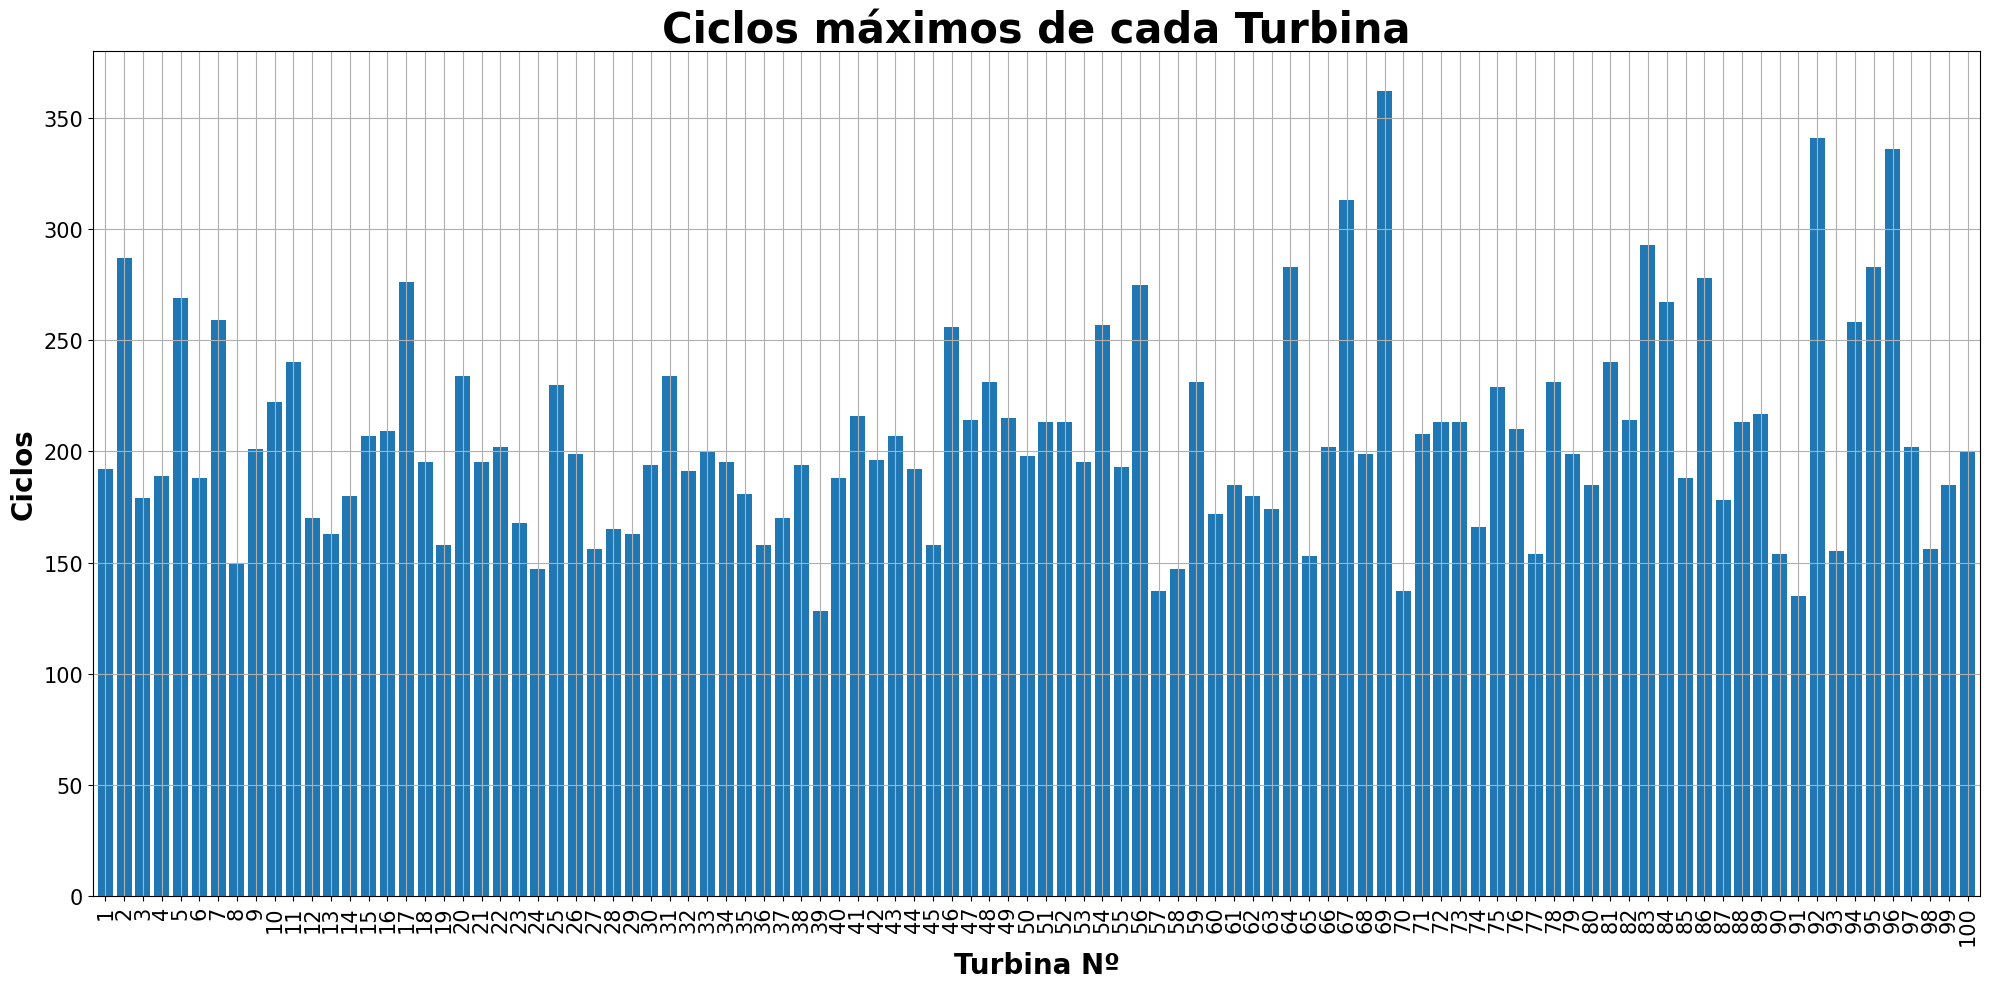

In [10]:
ciclos_maximos = train[index_names].groupby('unit_number').max()
plt.figure(figsize=(20,10))
ax = ciclos_maximos['time_cycles'].plot(kind='bar', width=0.8, stacked=True, align='center')
plt.title('Ciclos máximos de cada Turbina',fontweight='bold',size=30)
plt.xlabel('Turbina Nº',fontweight='bold',size=20)
plt.xticks(size=15)
plt.ylabel('Ciclos',fontweight='bold',size=20)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout()
plt.show()

Distribución de los ciclos

Text(0.5, 9.444444444444459, 'Ciclos máximos')

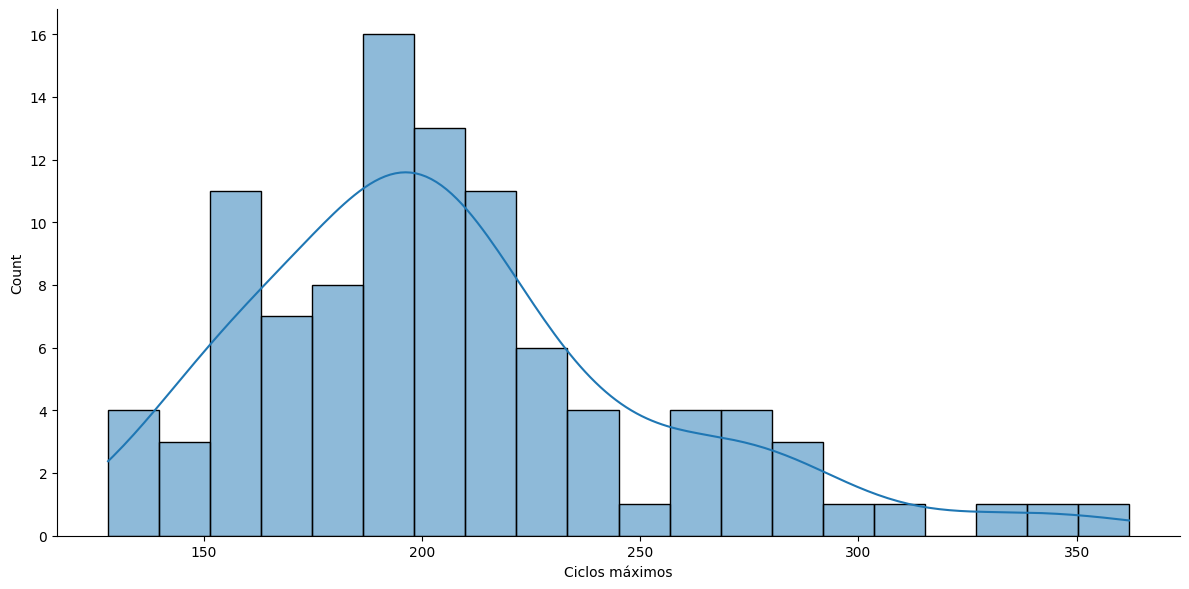

In [11]:
sns.displot(ciclos_maximos['time_cycles'], kde=True, bins=20, height=6, aspect=2)
plt.xlabel('Ciclos máximos')

---

### Añadimos la columna RUL a la data

Indica los ciclos restantes de cada unidad antes de que falle.

In [12]:
def add_RUL_column(df):
    train_grouped_by_unit = df.groupby(by='unit_number')
    max_time_cycles = train_grouped_by_unit['time_cycles'].max()
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
    merged = merged.drop("max_time_cycle", axis=1) 
    return merged

In [13]:
train = add_RUL_column(train)

In [14]:
train[['unit_number','RUL']]

,unit_number,RUL
0,1,191
1,1,190
2,1,189
3,1,188
4,1,187
...,...,...
20626,100,4
20627,100,3
20628,100,2
20629,100,1


---

### Correlaciones

<Axes: >

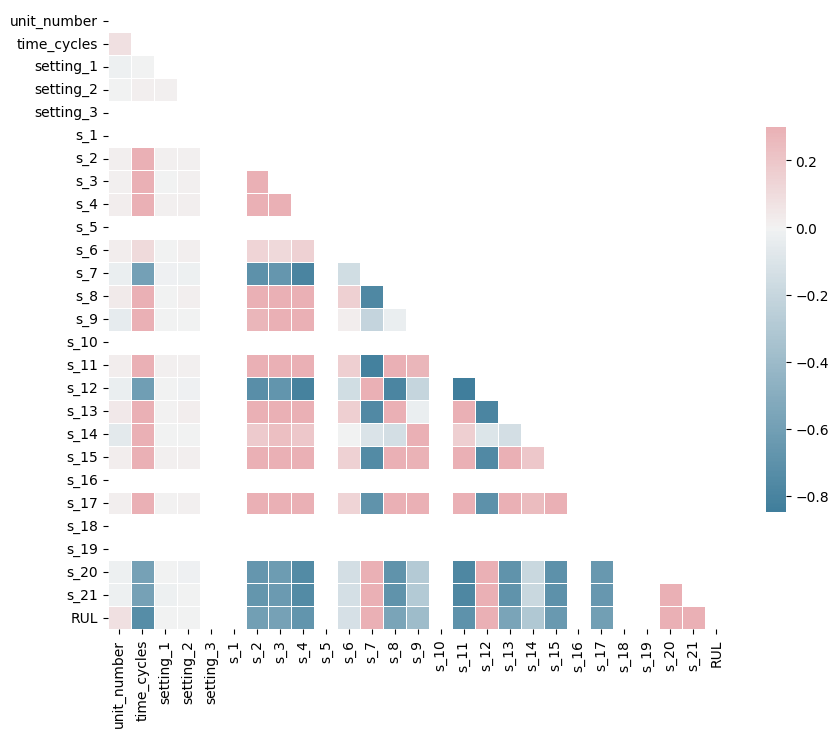

In [15]:
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(230, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

Vemos que algunas variables tienen una fuerte correlación con la columna a predecir "RUL" y otras que prácticamente no tienen correlación.

---

Asociamos los sensores a su significado.

In [16]:
Sensor_dictionary={}

dict_list=["(Fan inlet temperature) (◦R)",
           "(LPC outlet temperature) (◦R)",
           "(HPC outlet temperature) (◦R)",
           "(LPT outlet temperature) (◦R)",
           "(Fan inlet Pressure) (psia)",
           "(bypass-duct pressure) (psia)",
           "(HPC outlet pressure) (psia)",
           "(Physical fan speed) (rpm)",
           "(Physical core speed) (rpm)",
           "(Engine pressure ratio(P50/P2)",
           "(HPC outlet Static pressure) (psia)",
           "(Ratio of fuel flow to Ps30) (pps/psia)",
           "(Corrected fan speed) (rpm)",
           "(Corrected core speed) (rpm)",
           "(Bypass Ratio) ",
           "(Burner fuel-air ratio)",
           "(Bleed Enthalpy)",
           "(Required fan speed)",
           "(Required fan conversion speed)",
           "(High-pressure turbines Cool air flow)",
           "(Low-pressure turbines Cool air flow)"
           ]

i=1
for x in dict_list:
    Sensor_dictionary['s_' + str(i)] = x
    i+=1

Sensor_dictionary

{'s_1': '(Fan inlet temperature) (◦R)',
 's_2': '(LPC outlet temperature) (◦R)',
 's_3': '(HPC outlet temperature) (◦R)',
 's_4': '(LPT outlet temperature) (◦R)',
 's_5': '(Fan inlet Pressure) (psia)',
 's_6': '(bypass-duct pressure) (psia)',
 's_7': '(HPC outlet pressure) (psia)',
 's_8': '(Physical fan speed) (rpm)',
 's_9': '(Physical core speed) (rpm)',
 's_10': '(Engine pressure ratio(P50/P2)',
 's_11': '(HPC outlet Static pressure) (psia)',
 's_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 's_13': '(Corrected fan speed) (rpm)',
 's_14': '(Corrected core speed) (rpm)',
 's_15': '(Bypass Ratio) ',
 's_16': '(Burner fuel-air ratio)',
 's_17': '(Bleed Enthalpy)',
 's_18': '(Required fan speed)',
 's_19': '(Required fan conversion speed)',
 's_20': '(High-pressure turbines Cool air flow)',
 's_21': '(Low-pressure turbines Cool air flow)'}

#### Evolución de las variables con respecto a la vida útil restante (RUL)

In [17]:
def plot_signal(df, Sensor_dic, signal_name):
    plt.figure(figsize=(13,5))
    for i in df['unit_number'].unique():
        if (i % 10 == 0):   # ploteamos las señales de solo 10 sensores (20)
            plt.plot('RUL', signal_name, data=df[df['unit_number']==i].rolling(10).mean())

    plt.xlim(250, 0)  # invertimos el eje x para que la vida útil termine en cero
    plt.xticks(np.arange(0, 300, 25))
    plt.ylabel(Sensor_dic[signal_name])
    plt.xlabel('Remaining Useful Life')
    plt.show()


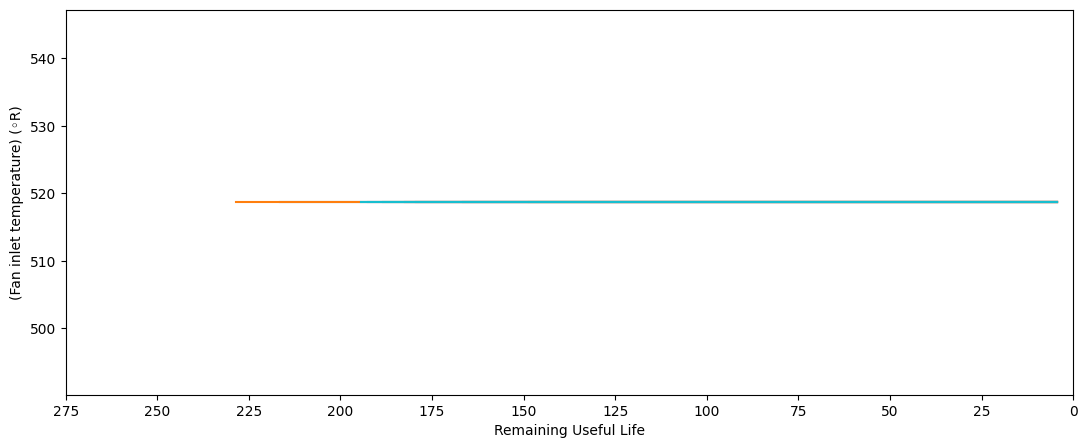

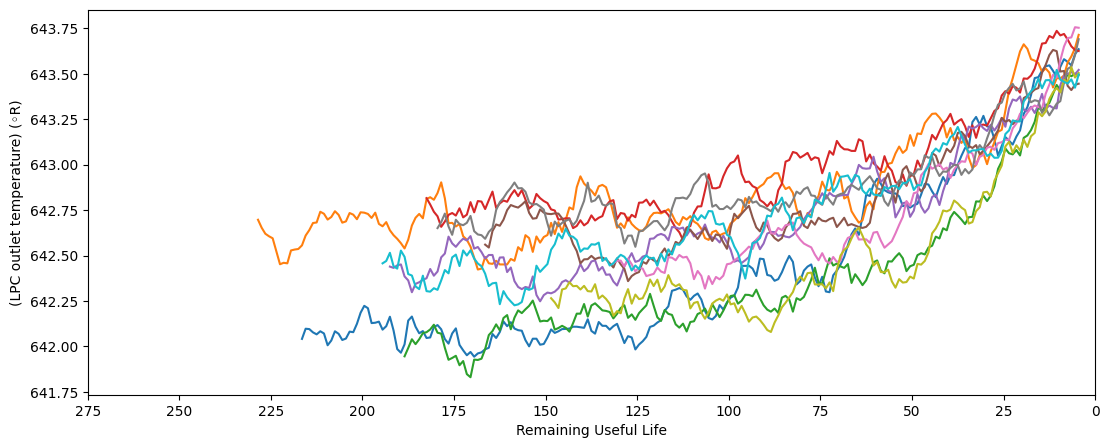

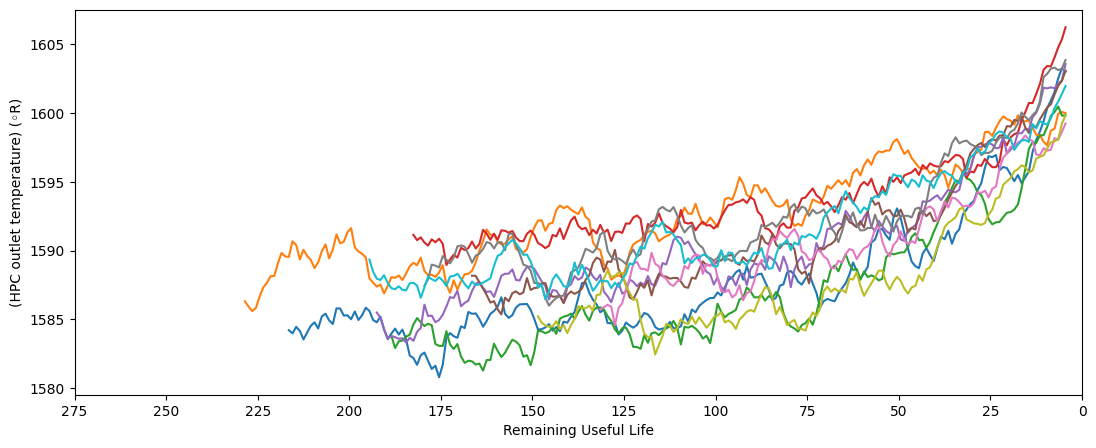

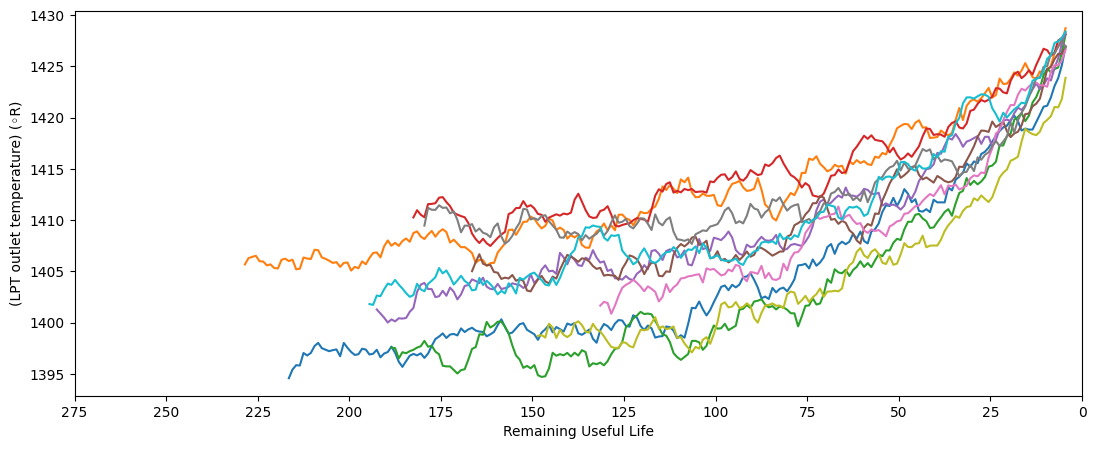

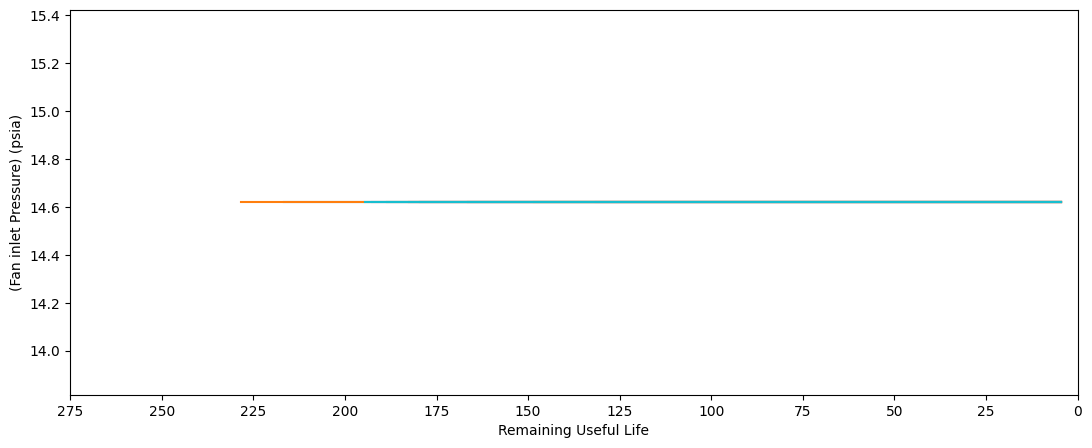

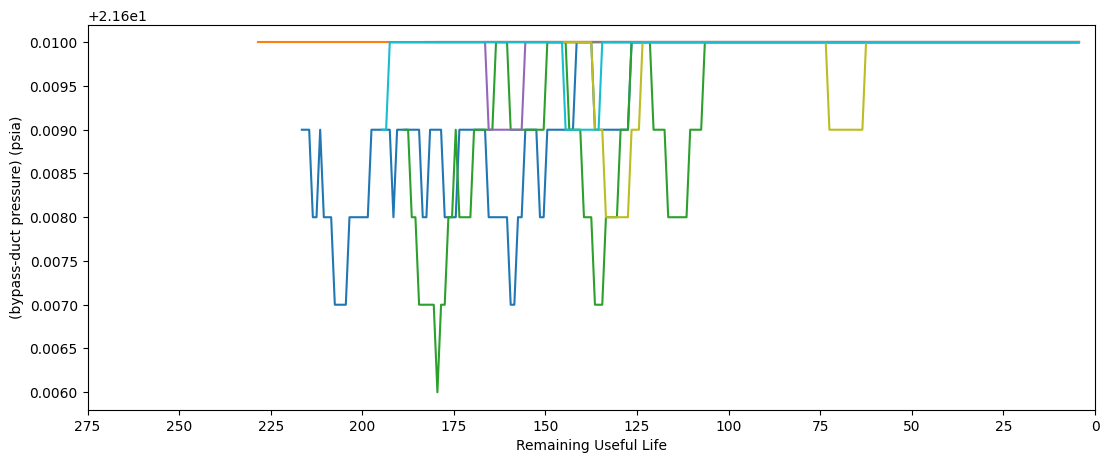

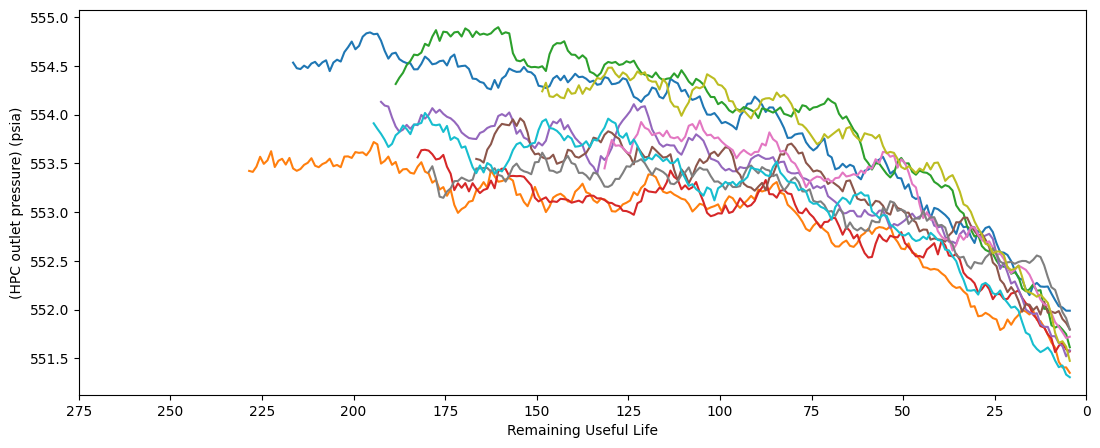

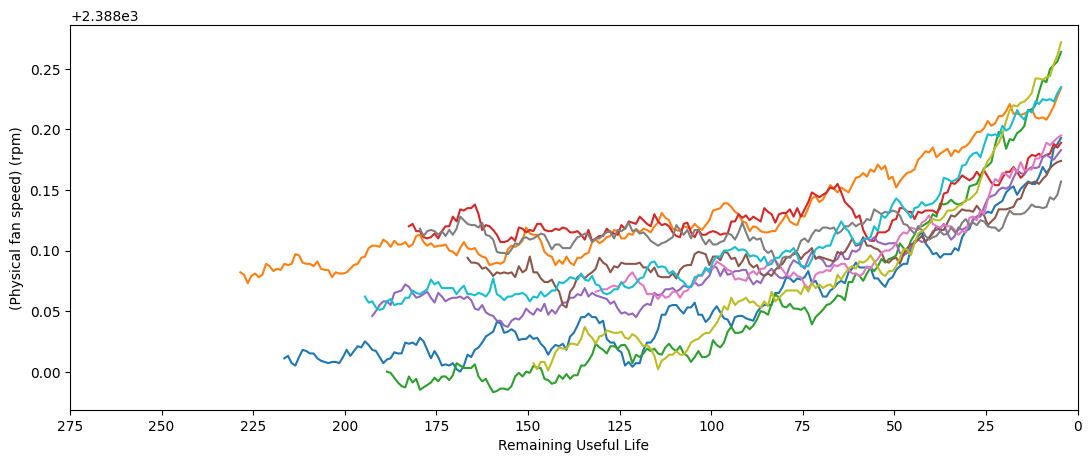

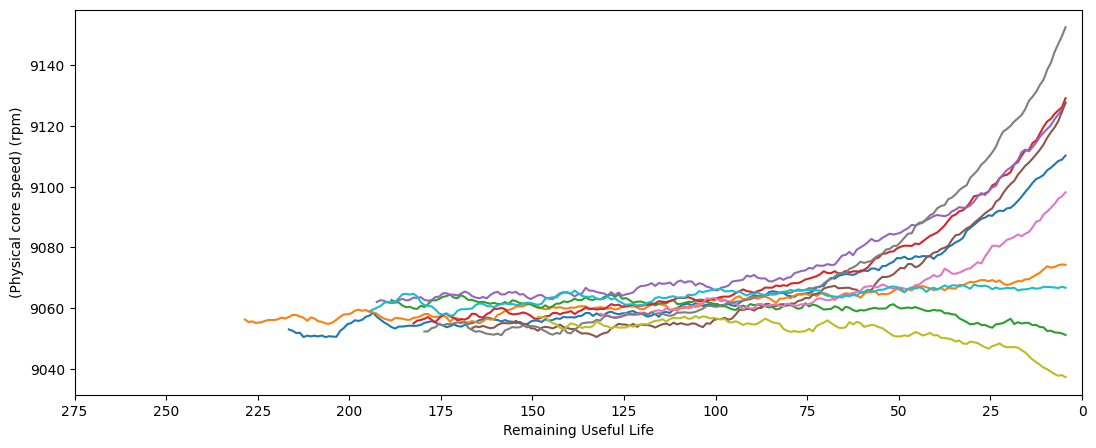

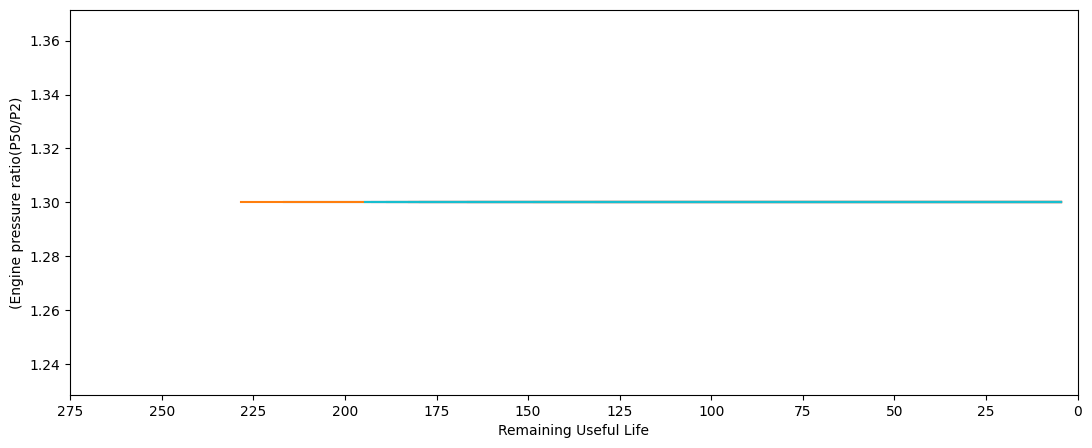

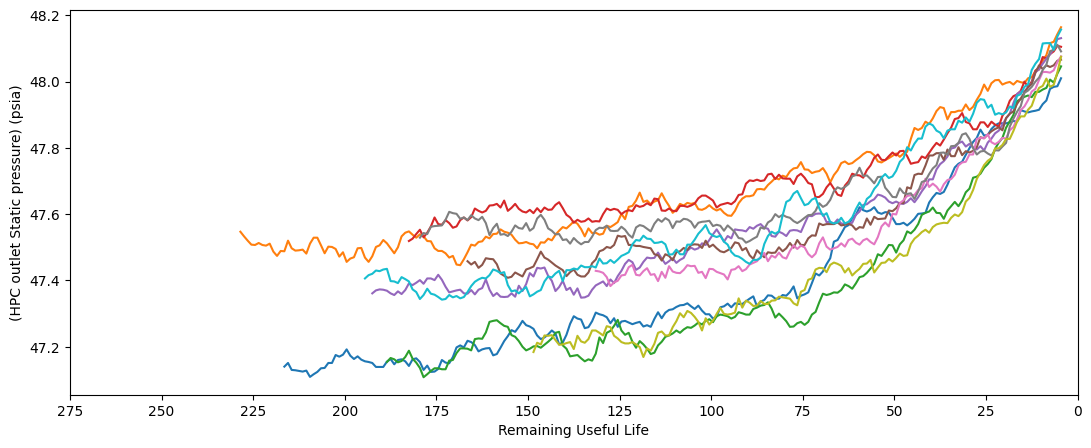

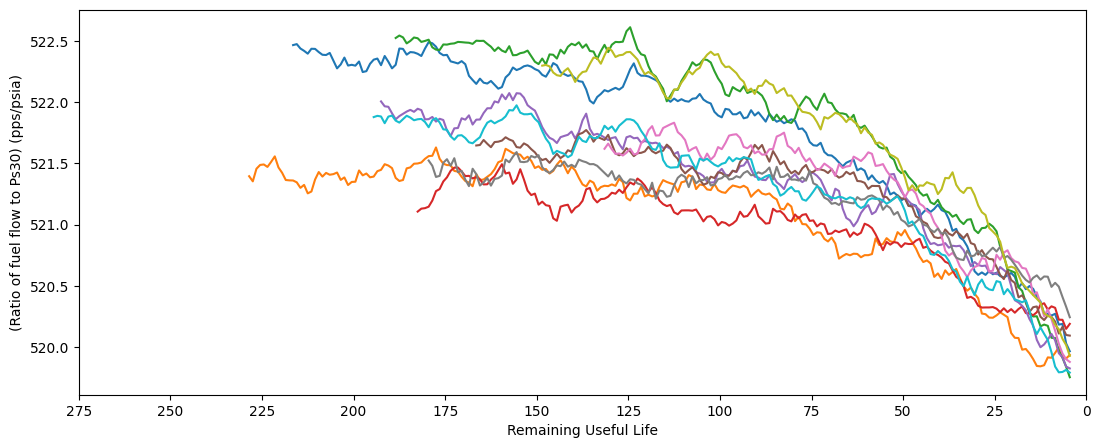

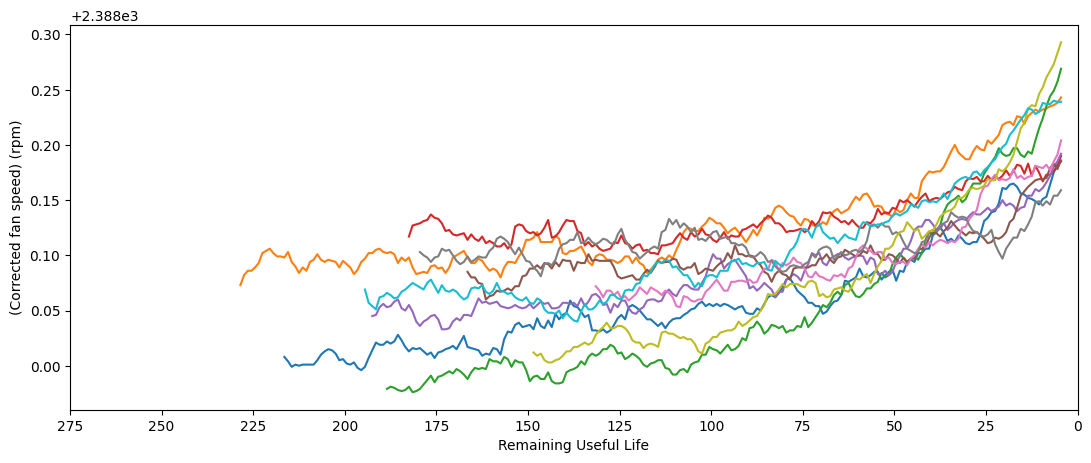

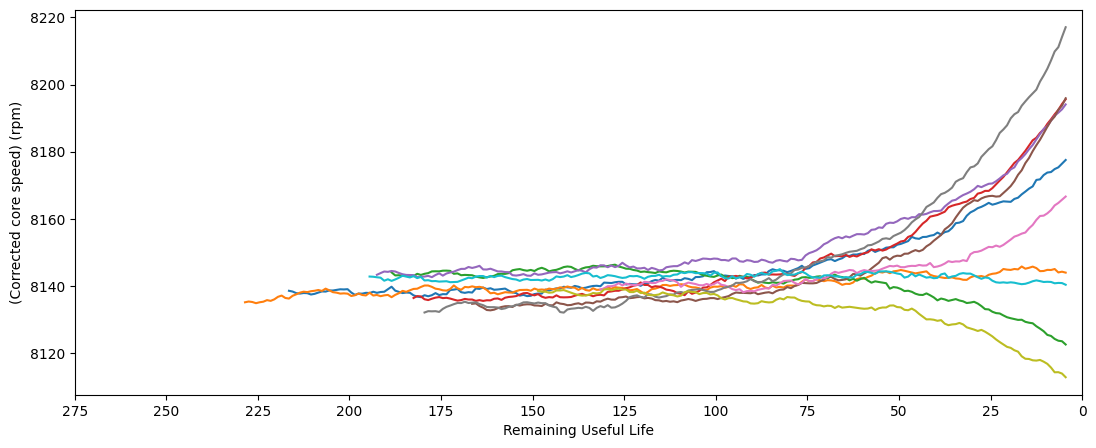

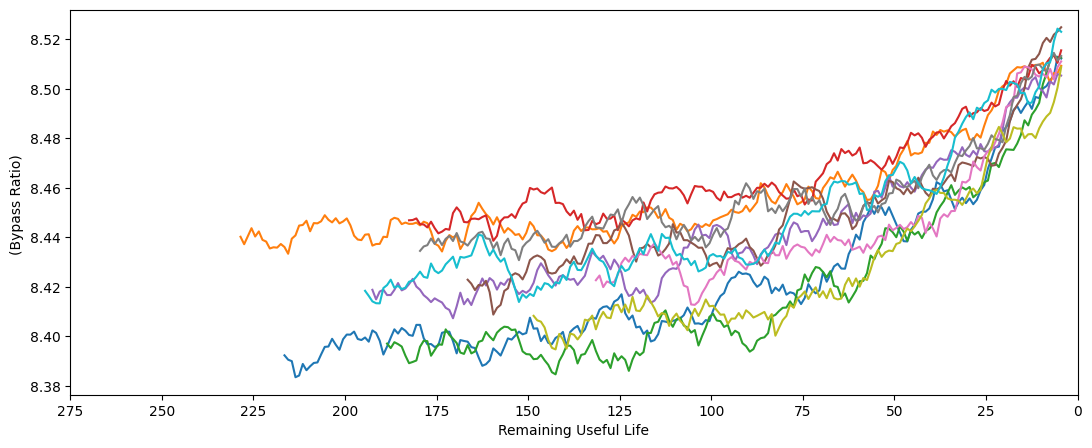

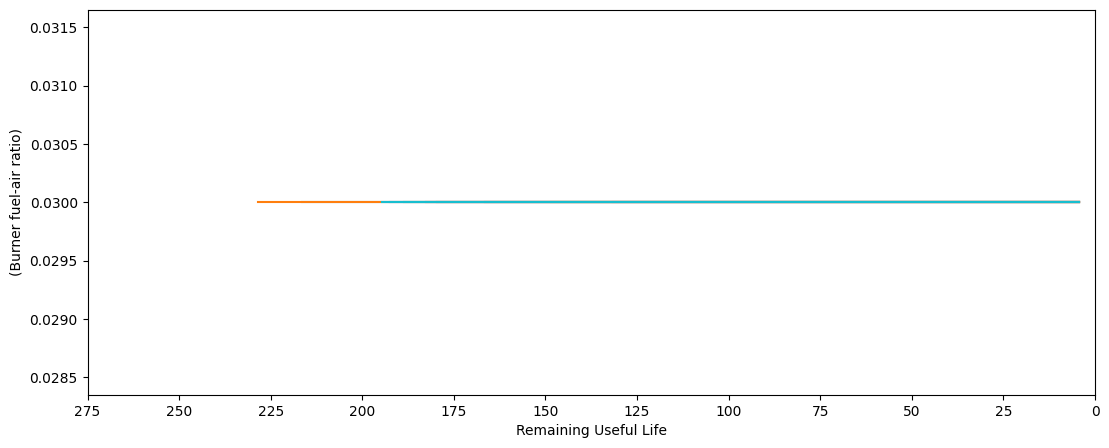

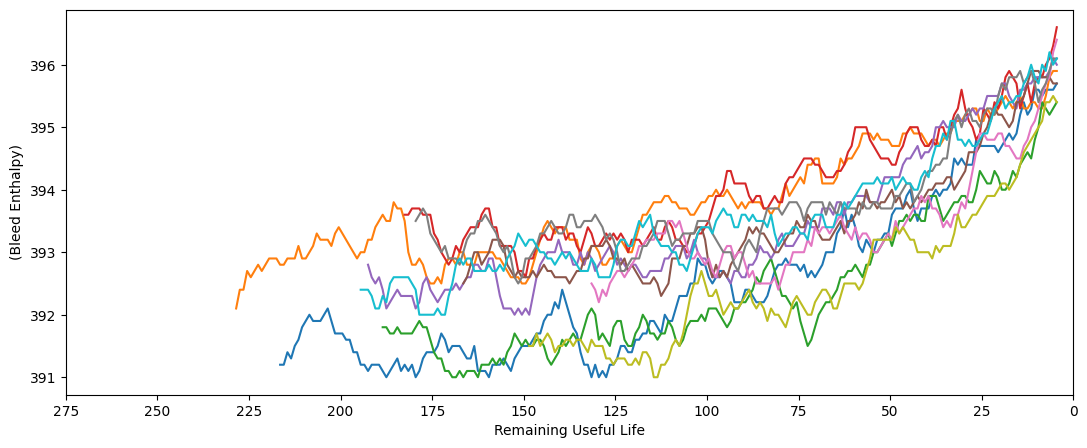

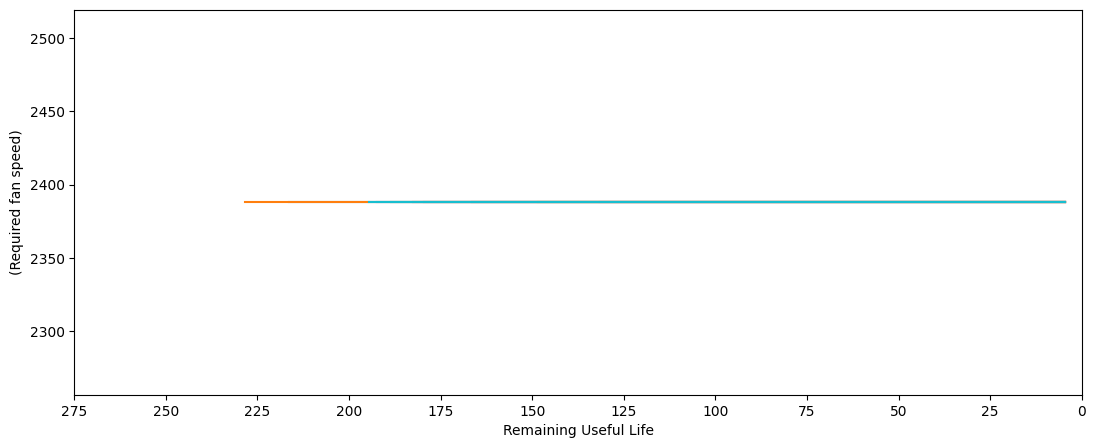

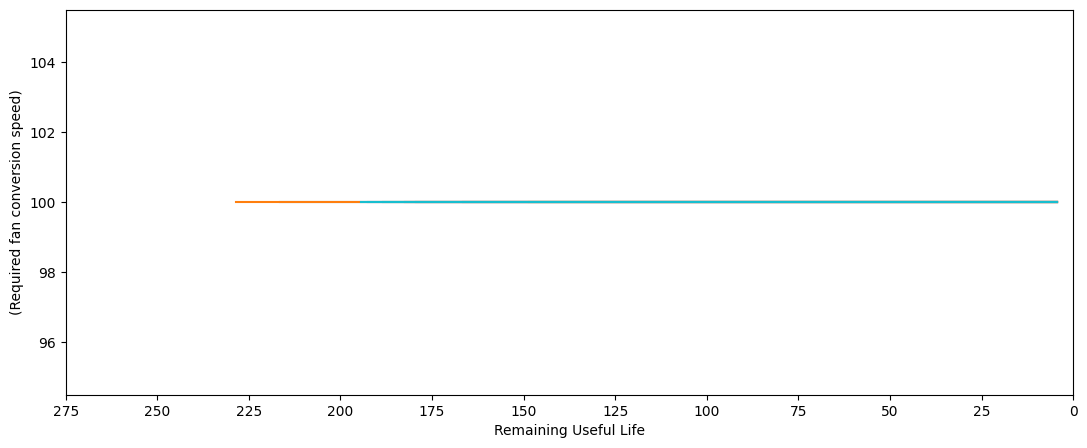

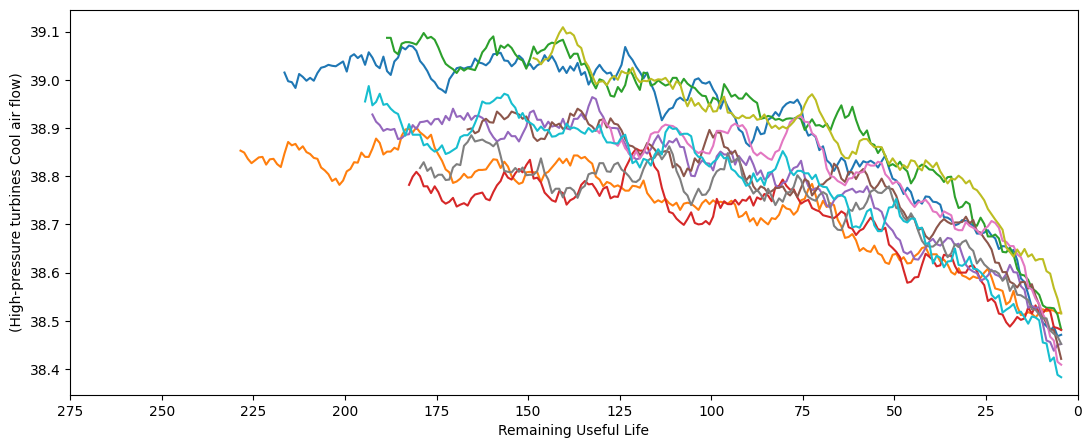

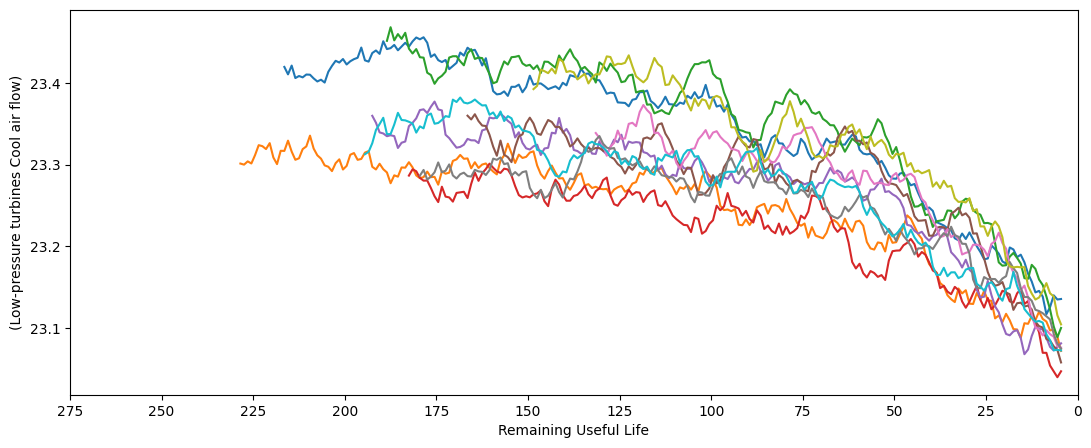

In [18]:
for i in range(1,22):
    try:
        plot_signal(train, Sensor_dictionary,'s_'+str(i))
    except:
        pass

Vemos que algunas variables (sensores) no tienen influencia en la vida de las turbinas, mas luego las vamos a descartar.

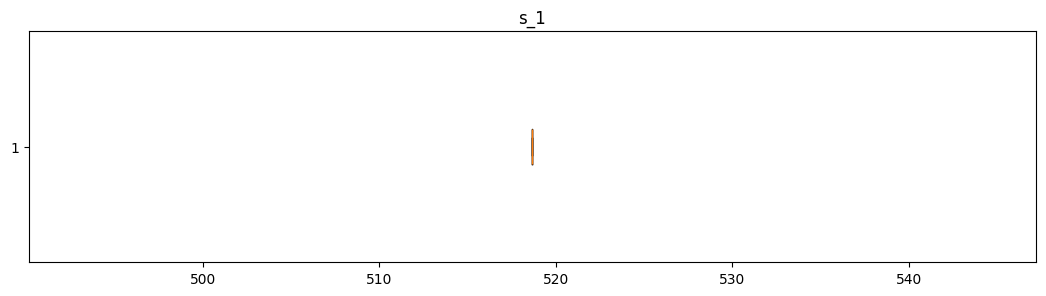

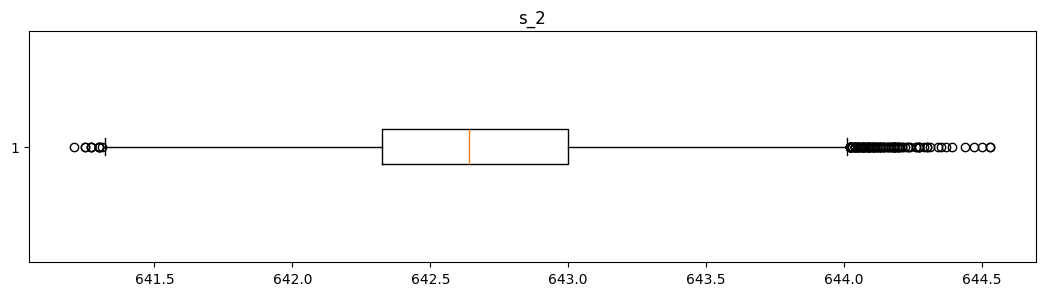

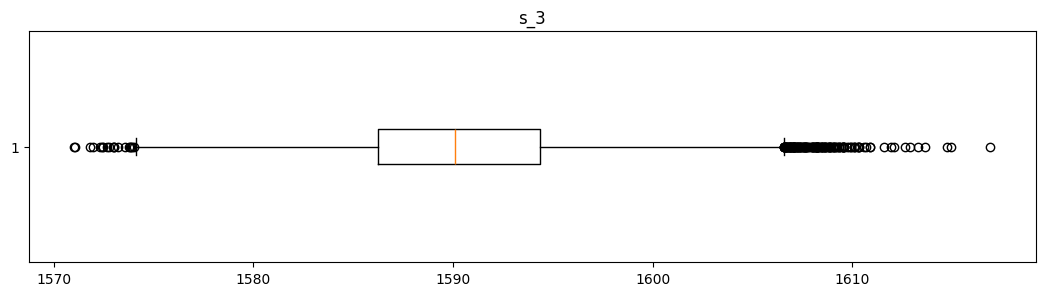

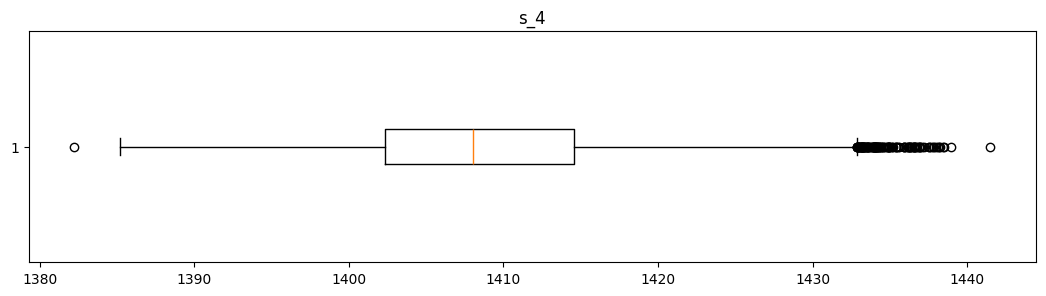

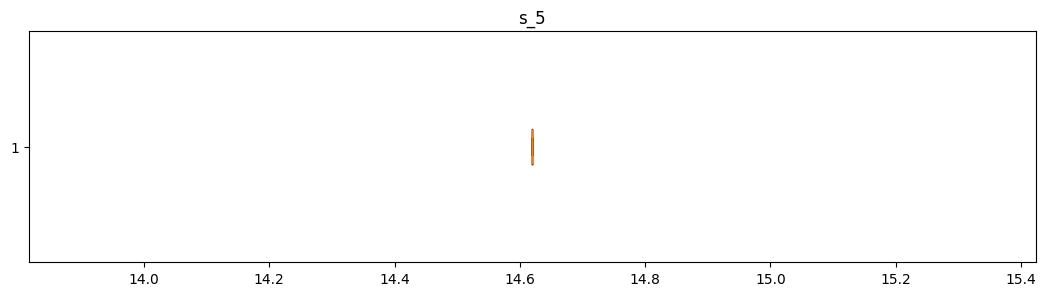

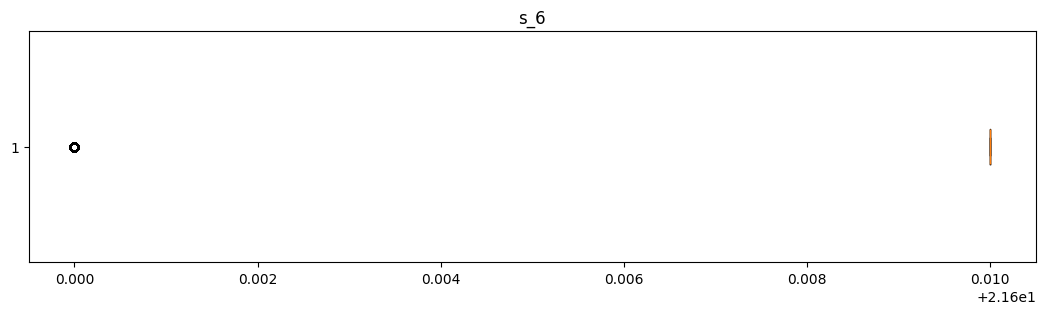

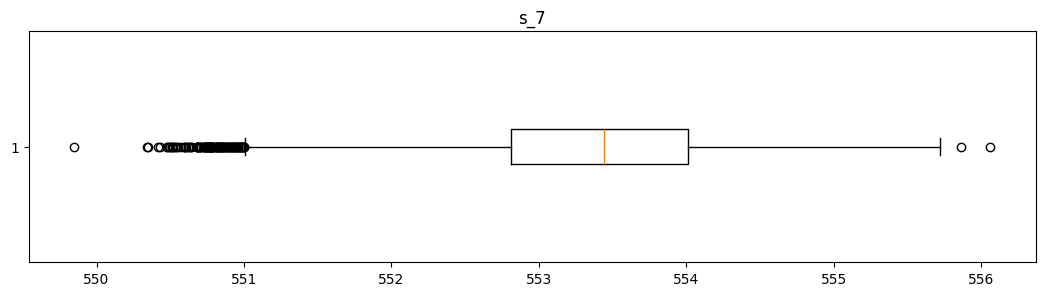

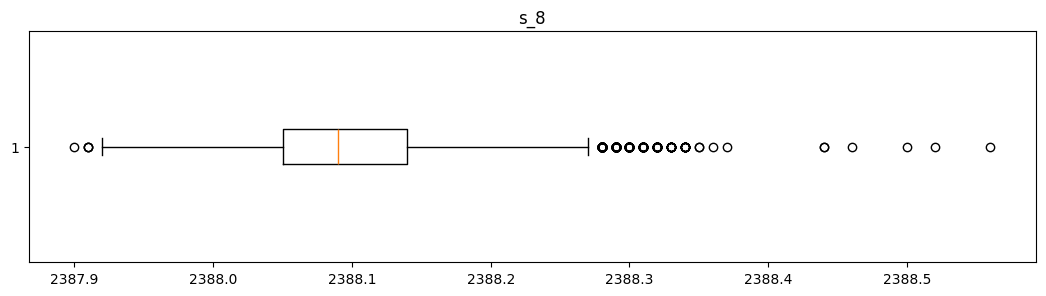

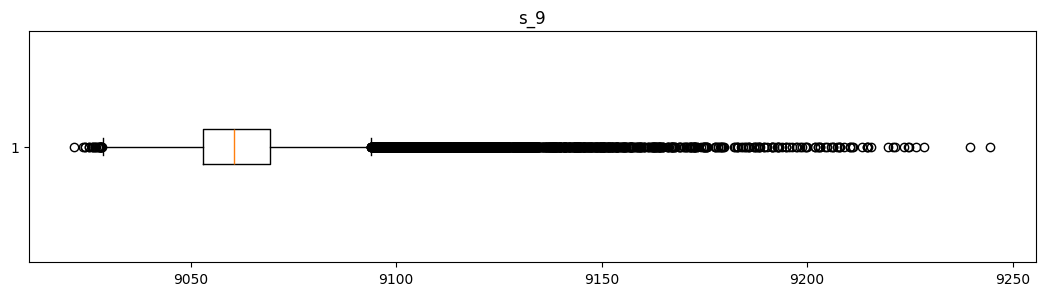

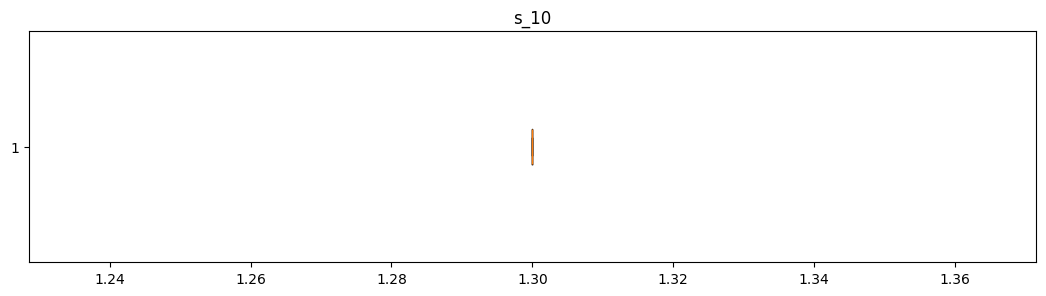

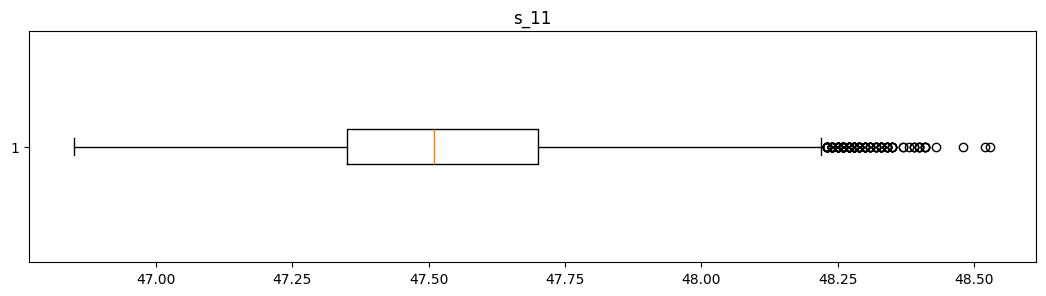

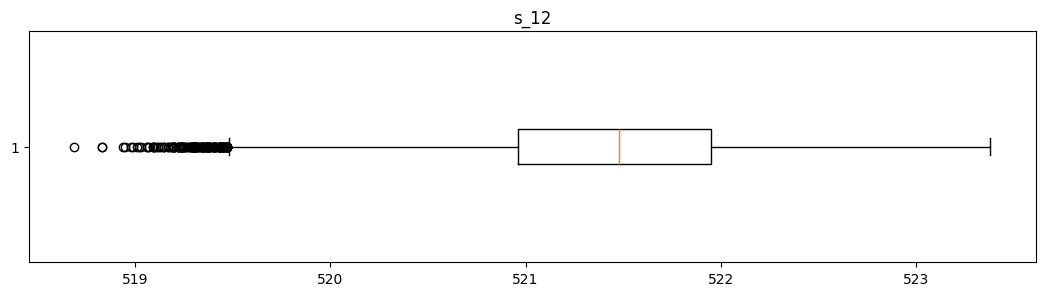

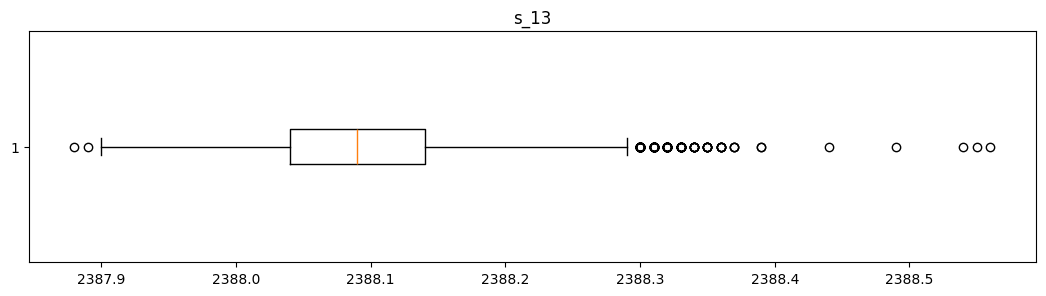

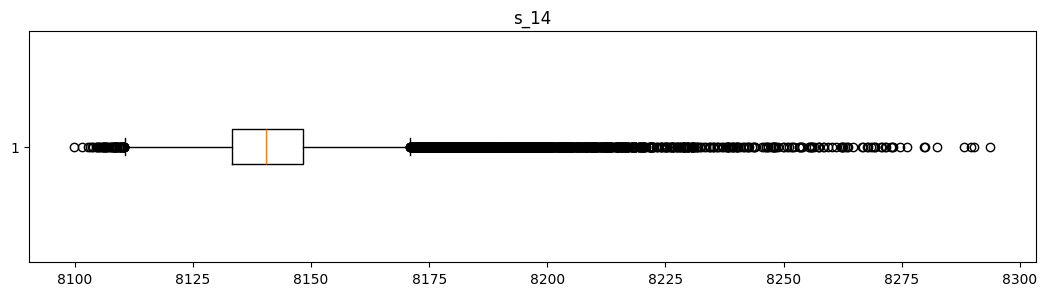

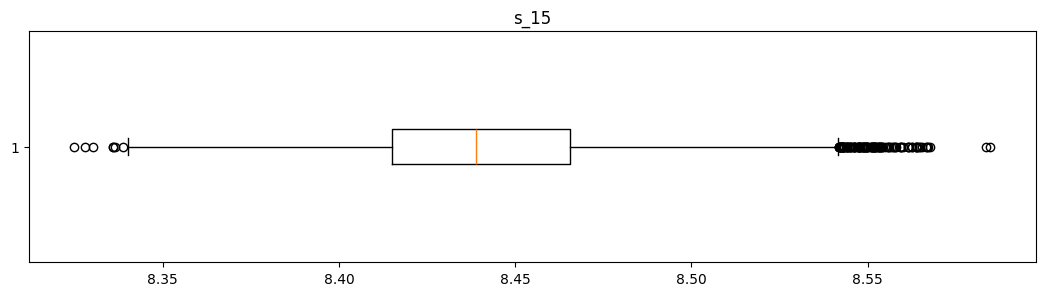

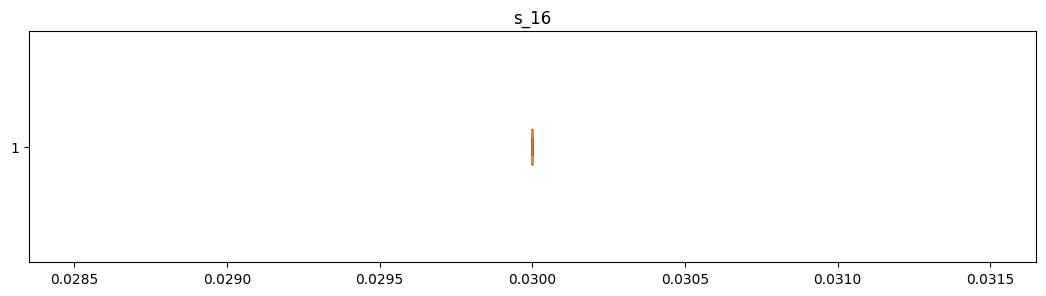

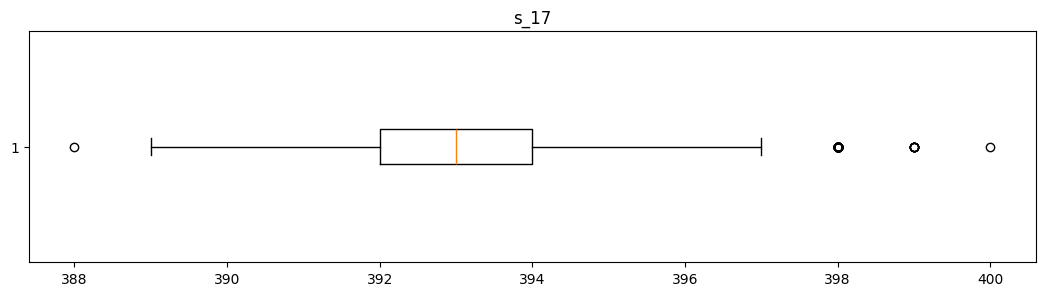

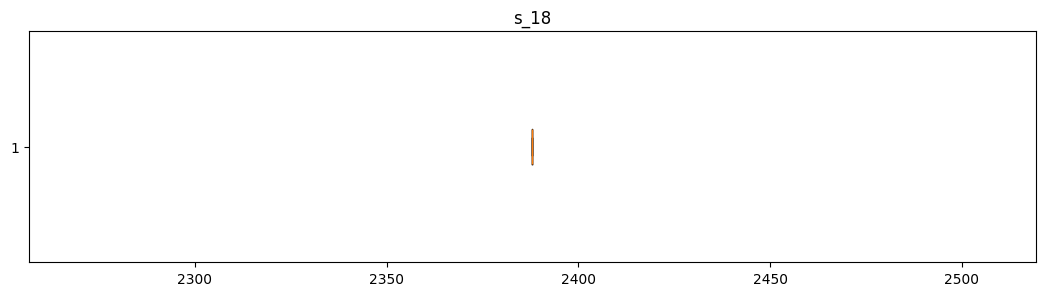

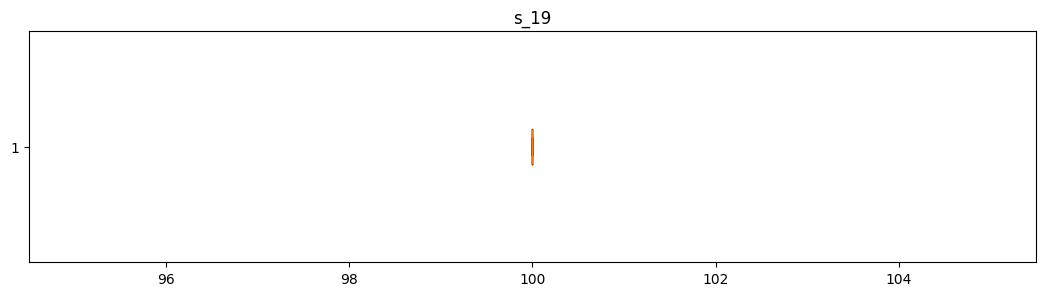

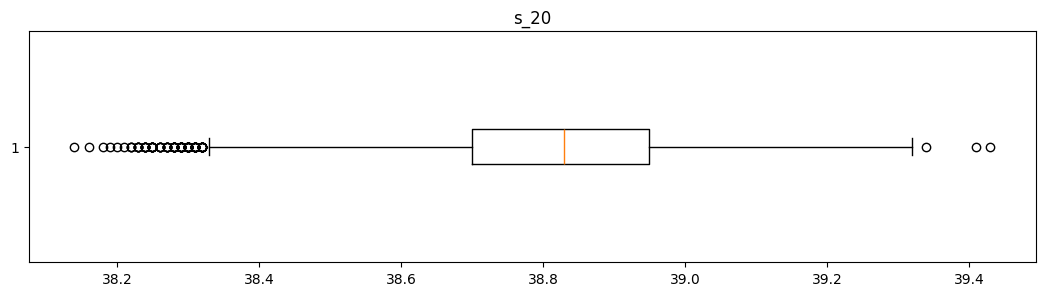

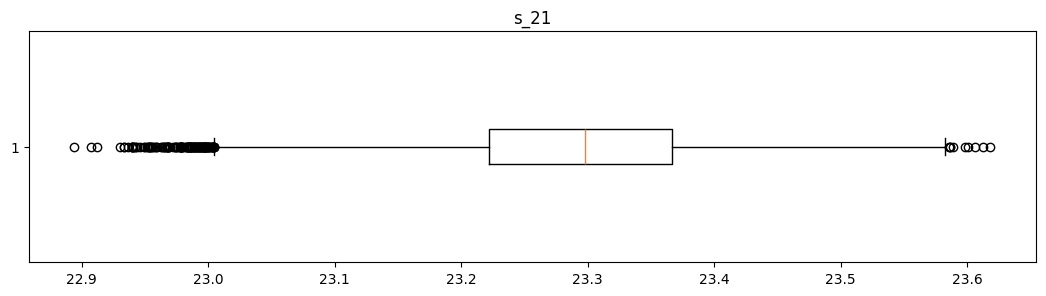

In [19]:
for x in sensor_names:
    plt.figure(figsize=(13,3))
    plt.boxplot(train[x], vert=False)
    plt.title(x)
    plt.show()

Podemos ver que los sensores 1,5,10,16,18,19 son constantes, pero el resto de los sensores tienen algunos outlayers, por lo que vamos a escalar la data.

In [20]:
train.loc[:,'s_1':].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
s_1,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
s_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s_5,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200
s_6,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
s_7,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
s_8,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
s_9,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
s_10,20631.0,1.300000,0.000000e+00,1.3000,1.3000,1.3000,1.3000,1.3000


También podemos observar que logicamente los sensores no manejan escalas iguales y no siguen una distribución normal, por lo que vamos a usar min-max scaler.

**Función min-max scaler:** Tranforma las variables, conteniéndolas dentro de un cierto rango.

<img src='_src/min_max_scaler.jpg' width="350" height="100">

##### Eliminamos variables innecesarias (labels y settings)

In [21]:
train.columns

Index(['unit_number', 'time_cycles', 'setting_1', 'setting_2', 'setting_3',
       's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19',
       's_20', 's_21', 'RUL'],
      dtype='object')

In [22]:
drop_labels = index_names + setting_names

X_train = train.drop(columns=drop_labels).copy()

X_train, X_test, y_train, y_test = train_test_split(X_train, X_train['RUL'], test_size=0.3, random_state=137)

##### Normalizamos la data

In [23]:
scaler = MinMaxScaler()

# Eliminamos la variable a predecir
X_train.drop(columns=['RUL'], inplace=True)
X_test.drop(columns=['RUL'], inplace=True)

X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.fit_transform(X_test)

# Conservamos solo el último valor de cada turbina, para coincidir con el largo de y_valid
X_valid = valid.groupby('unit_number').last().reset_index().drop(columns=drop_labels)

X_valid_s = scaler.fit_transform(X_valid)


In [24]:
print(X_valid_s.shape)
print(y_valid.shape)

(100, 21)
(100, 1)


#### Vemos la distribución de las variables

array([[<Axes: title={'center': 's_2'}>, <Axes: title={'center': 's_3'}>,
        <Axes: title={'center': 's_4'}>, <Axes: title={'center': 's_7'}>],
       [<Axes: title={'center': 's_8'}>, <Axes: title={'center': 's_9'}>,
        <Axes: title={'center': 's_11'}>,
        <Axes: title={'center': 's_12'}>],
       [<Axes: title={'center': 's_13'}>,
        <Axes: title={'center': 's_14'}>,
        <Axes: title={'center': 's_15'}>,
        <Axes: title={'center': 's_17'}>],
       [<Axes: title={'center': 's_20'}>,
        <Axes: title={'center': 's_21'}>, <Axes: >, <Axes: >]],
      dtype=object)

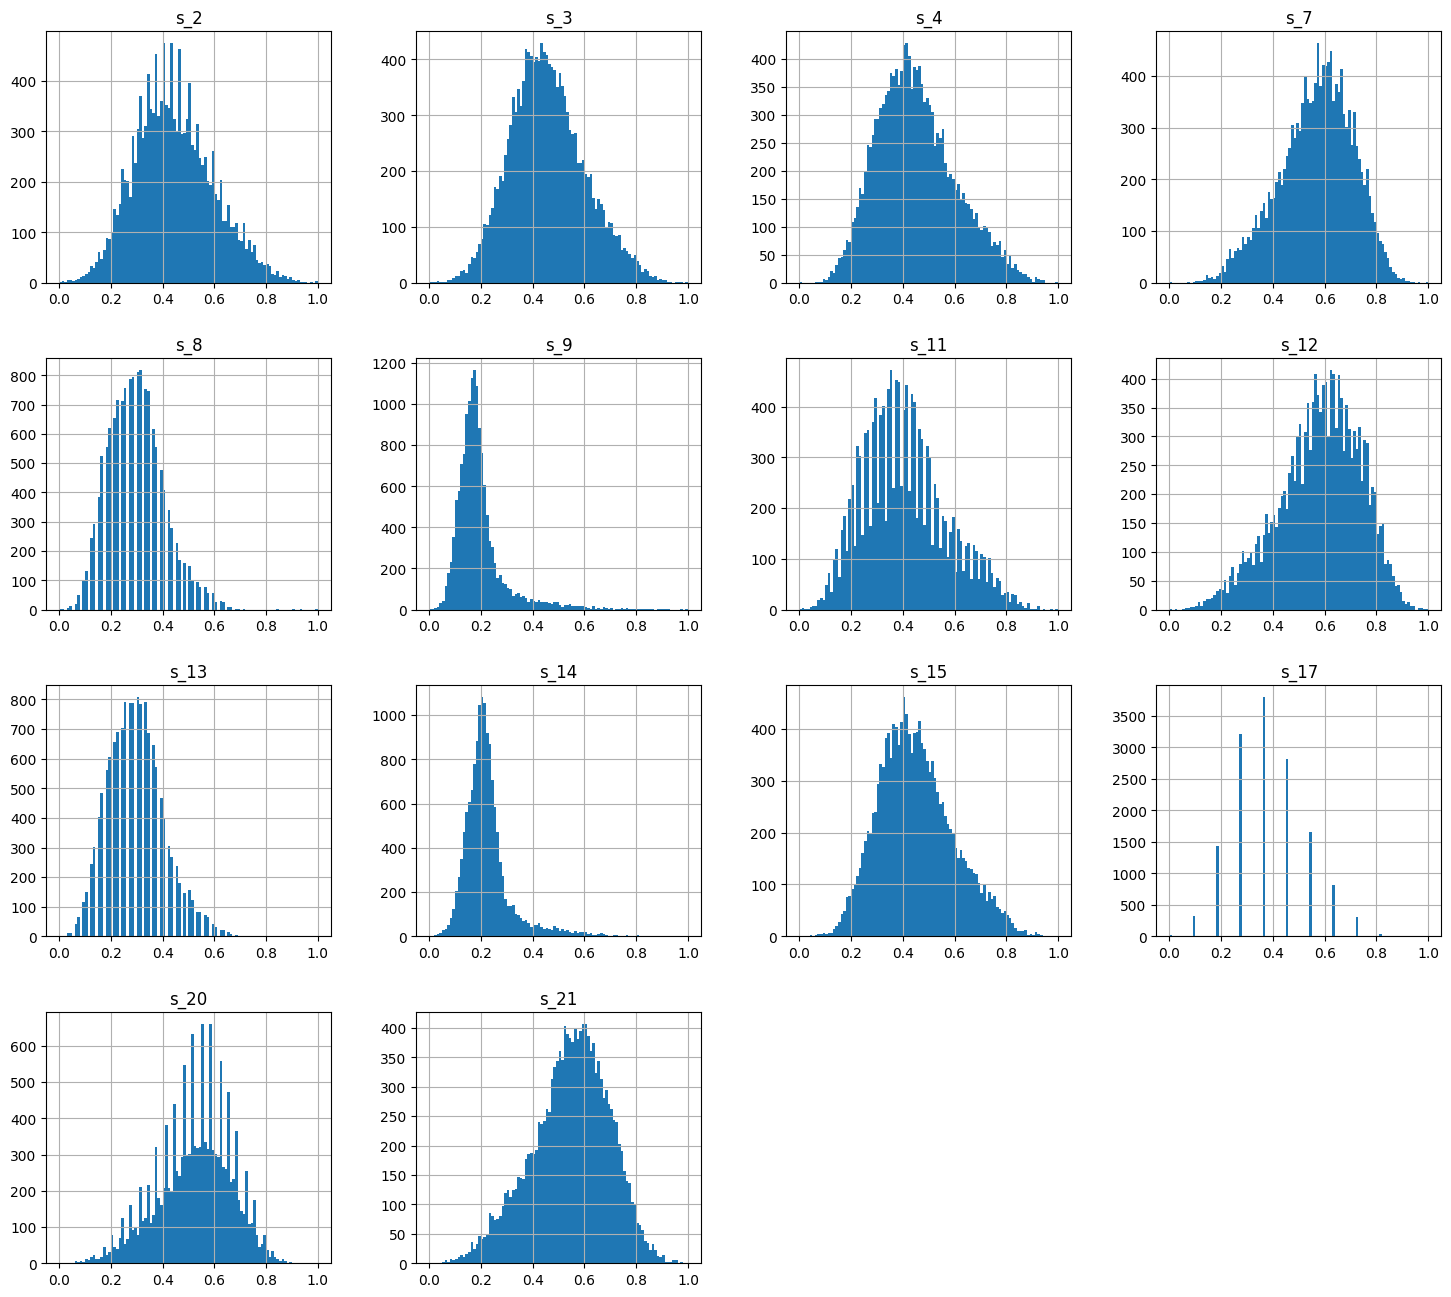

In [25]:
sensor_names=[f's_{i}' for i in range(1,22) if i not in [1,5,6,10,16,18,19]]
pd.DataFrame(X_train_s, columns=[f's_{i}' for i in range(1,22)])[sensor_names].hist(bins=100, figsize=(18,16))

## Instanciación e Implementación de modelos.

#### Regresión lineal

In [26]:
class Linear_Regression():
    def __init__(self, lr=0.01, iterations=150 ):
        self.lr = lr
        self.iterations = iterations

    def fit(self, X, Y):
        self.l, self.p = X.shape
        # weight initializer
        self.W = np.zeros(self.p)
        self.b = 0
        self.X = X
        self.Y = Y
        # gradientlearning
        for i in range(self.iterations):
            self.weight_updater()
        return self

    def weight_updater(self):
        Y_pred = self.predict(self.X)
        #  gradients  
        dW = - (2 * (self.X.T).dot(self.Y - Y_pred)) / self.l
        db = - 2 * np.sum(self.Y - Y_pred) / self.l
        # new weights assigned
        self.b = self.b - self.lr * db
        self.W = self.W - self.lr * dW
        return self

    def predict( self, X ) :
          # Y_pr=X.W+b
        return X.dot( self.W ) + self.b

### Fución para evaluar resultados

In [27]:
# R2 score y RMSE
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print(f'{label} set RMSE:{rmse}, R2:{variance}')

In [28]:
# función para graficar y comparar la data real con la predicha
def plot_predActual(y_test, y_test_hat):
  
    indices = np.arange(len(y_test_hat))
    wth= 0.6
    plt.figure(figsize=(70,30))
    true_values = [int(x) for x in y_test.values]
    predicted_values = list(y_test_hat)

    plt.bar(indices, true_values, width=wth,color='b', label='RUL verdadero')
    plt.bar([i for i in indices], predicted_values, width=0.5*wth, color='r', alpha=0.7, label='RUL predicho')

    plt.legend(prop={'size': 40})
    plt.tick_params(labelsize=40)

    plt.show()

### Primero con todas las variables y sin data histórica

#### Regresión lineal

In [29]:
lr=Linear_Regression() # Instanciación del modelo

lr.fit(X=X_train_s, Y=y_train) # Fitting

y_lr_train = lr.predict(X_train_s) # Predicción sobre train data
evaluate(y_train,y_lr_train, label='train')

y_lr_test = lr.predict(X_test_s) # Predicción sobre test data
evaluate(y_test, y_lr_test, label='test')

y_lr_valid = lr.predict(X_valid_s) # Predicción sobre data de validación
evaluate(y_valid, y_lr_valid, label='valid')

train set RMSE:55.93363057735554, R2:0.3358049172522407
test set RMSE:56.16912978829695, R2:0.3458752835237675
valid set RMSE:35.608224197549475, R2:0.26575484882995914


### SVR (Support Vector Regression)

In [30]:
regressor = SVR(kernel='rbf')

regressor.fit(X_train_s, y_train) # Fitting

y_svr_train = regressor.predict(X_train_s) # Predicción sobre train data
evaluate(y_train, y_svr_train, label='train')

y_svr_test = regressor.predict(X_test_s) # Predicción sobre test data
evaluate(y_test, y_svr_test, label='test')

y_svr_valid = lr.predict(X_valid_s) # Predicción sobre data de validación
evaluate(y_valid, y_svr_valid, label='valid')

train set RMSE:43.16985770869024, R2:0.6043502724594128
test set RMSE:45.26887208227022, R2:0.5751217340167314
valid set RMSE:35.608224197549475, R2:0.26575484882995914


#### Random Forest Regressor

In [31]:
rf = RandomForestRegressor(max_features="sqrt", random_state=42)

rf.fit(X_train_s, y_train) # Fitting

y_rf_train = rf.predict(X_train_s) # Predicción sobre train data
evaluate(y_train,y_rf_train, label='train')

y_rf_test = rf.predict(X_test_s) # Predicción sobre test data
evaluate(y_test, y_rf_test, label='test')

y_rf_valid = rf.predict(X_valid_s) # Predicción sobre data de validación
evaluate(y_valid, y_rf_valid, label='valid')

train set RMSE:15.285448481982453, R2:0.9503972210745346
test set RMSE:42.874440220256204, R2:0.6188796890852047
valid set RMSE:31.177121980708872, R2:0.4371242999471412


Graficamos con respecto a la prediccón de Random Forest, que nos dio mejor resultado

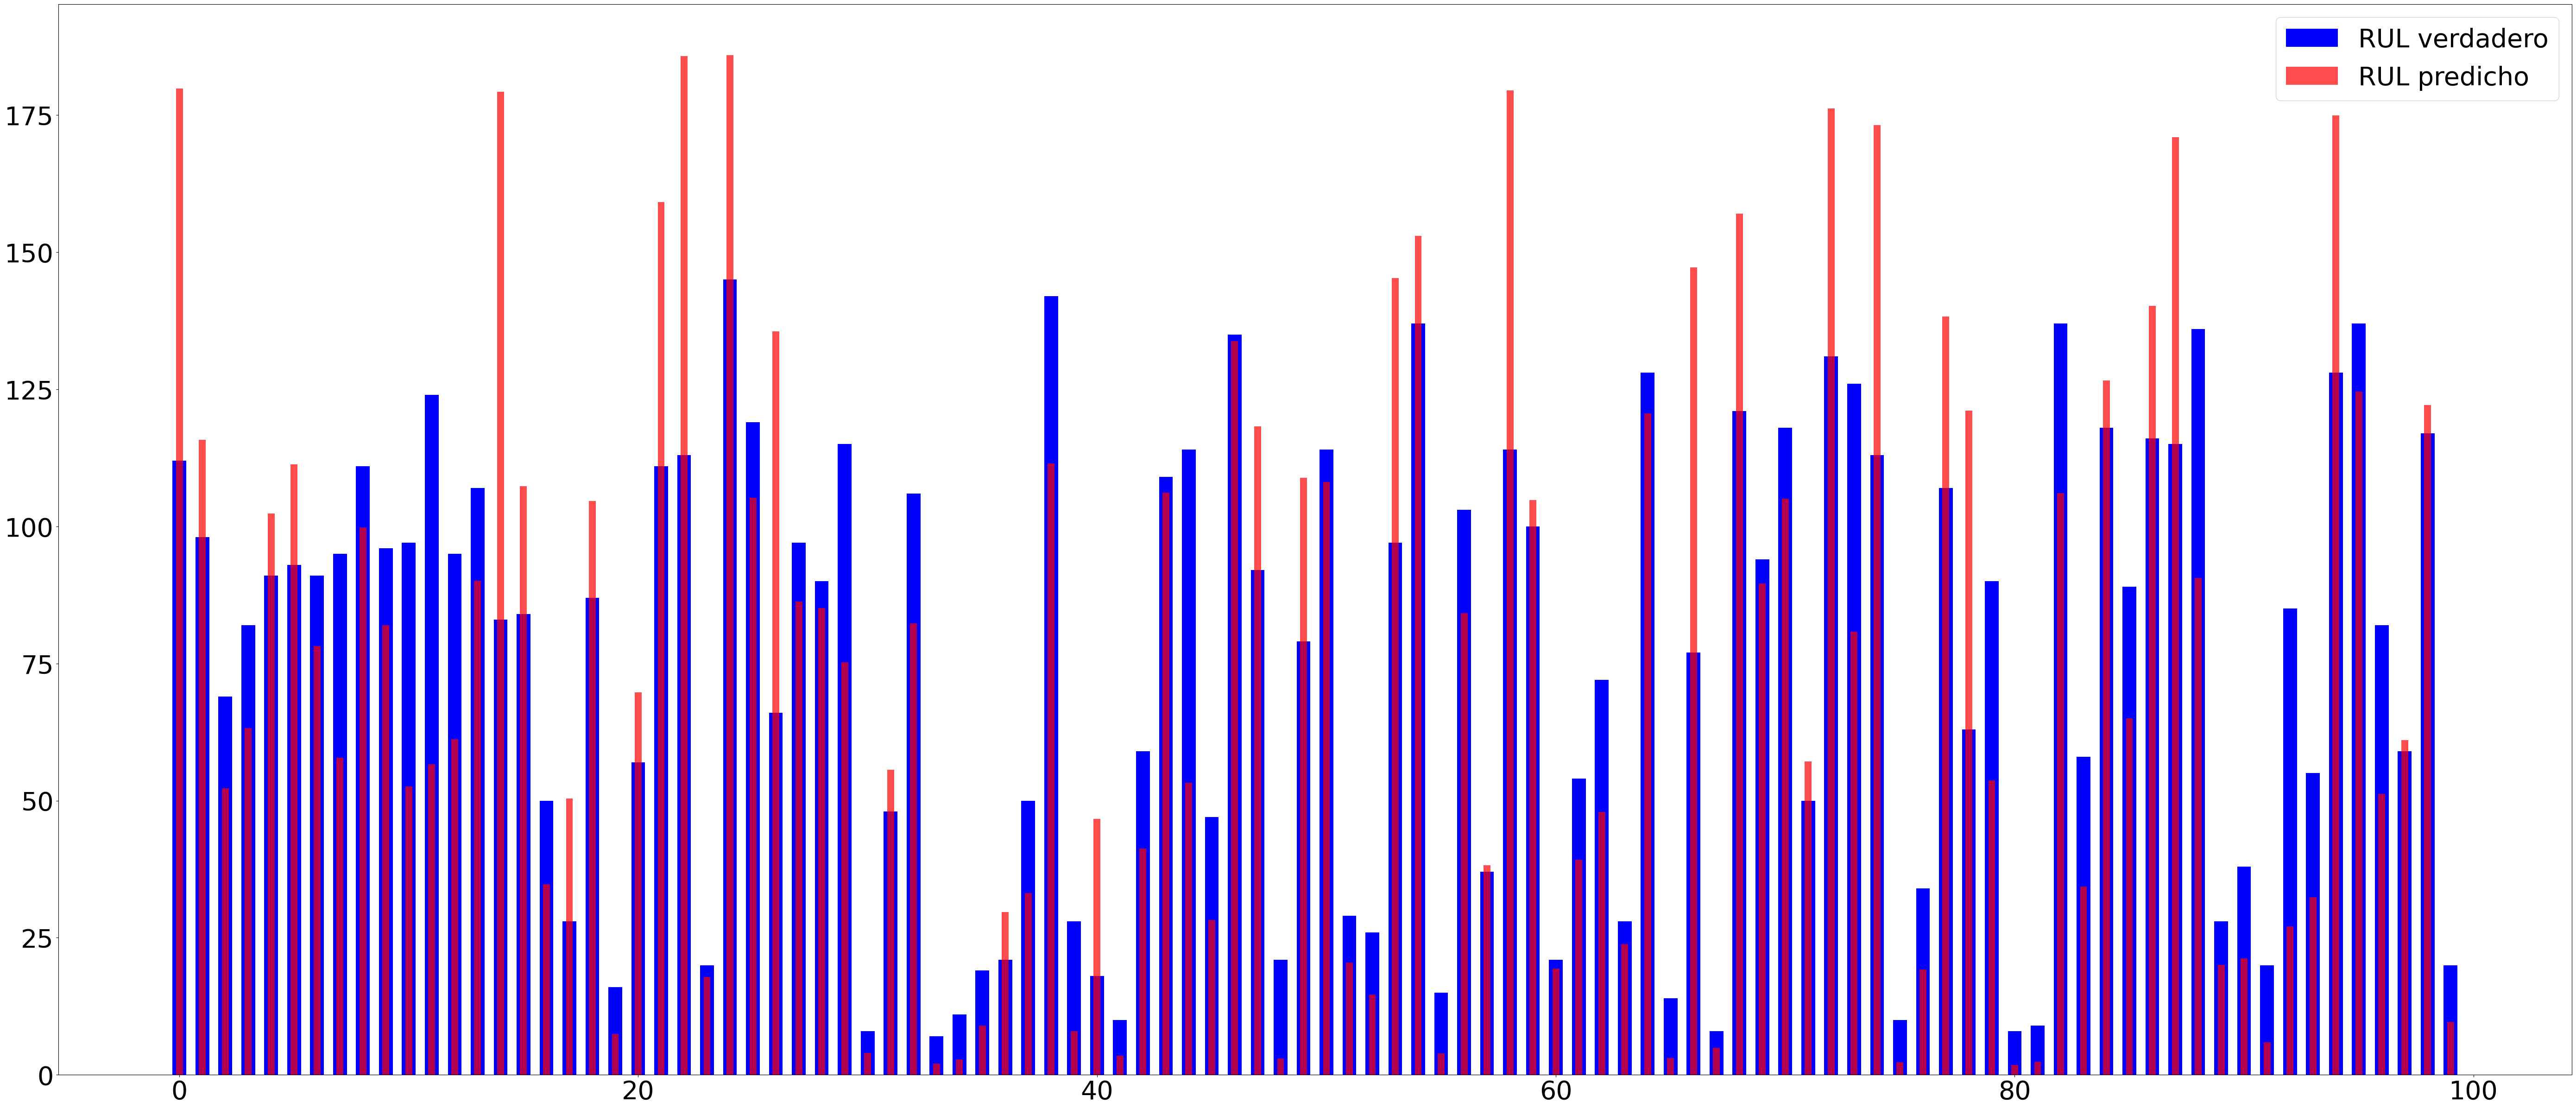

In [32]:
plot_predActual(y_valid, y_rf_valid)

---

### Ahora probamos sin sensores inútiles ni data histórica.

Vamos a eliminar variables de sensores que son constantes.
In  this section we drop constant signals, and we noticed in the max_time_cycles plot that in most of the time the maximum value is in the interval [190,210], hence we will set the maximum RUL to 195 through RUL clipping,

Considering that every RUL higher than 195 is equivalent to 195 will help in the prediction process as it reduces some overhead without affecting the main objective as 195 is already a high RUL.

In [33]:
print(f'RUL máximo de train: {y_train.max()}')
print(f'RUL promedio de train: {y_train.mean()}\n')
print(f'RUL máximo de test: {y_test.max()}')
print(f'RUL promedio de test: {y_test.mean()}\n')
print(f'RUL máximo de validación: {y_valid.max()}')
print(f'RUL promedio de validación: {y_valid.mean()}')

RUL máximo de train: 360
RUL promedio de train: 107.53410428640676

RUL máximo de test: 361
RUL promedio de test: 108.4465266558966

RUL máximo de validación: RUL    145
dtype: int64
RUL promedio de validación: RUL    75.52
dtype: float64


Vemos que en la data de validación tenemos un RUL promedio mucho menor que en la de entrenamiento, lo que no favorece para nada al modelo, no es lo ideal, pero en este caso en particular vamos a limitar las variables a un RUL máximo de 160

(array([1123., 1047., 1077., 1089.,  888.,  543.,  227.,  133.,   41.,
          22.]),
 array([  0. ,  36.1,  72.2, 108.3, 144.4, 180.5, 216.6, 252.7, 288.8,
        324.9, 361. ]),
 <BarContainer object of 10 artists>)

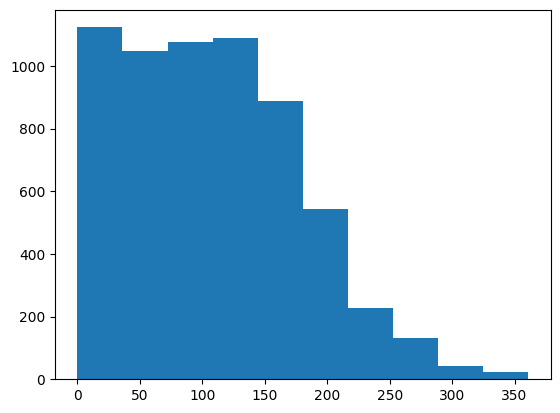

In [34]:
plt.hist(y_test)

In [35]:
y_train.shape

(14441,)

In [36]:
y_train

9154     110
12484    279
20448    182
10930     49
13513    117
        ... 
12417     63
4430     134
1171     132
18726    129
10974      5
Name: RUL, Length: 14441, dtype: int64

In [37]:
drop_labels2 = ['s_1', 's_5','s_6','s_10',  's_16', 's_18', 's_19']
X_train_2 = X_train.drop(columns=drop_labels2, axis=1)
X_test_2 = X_test.drop(columns=drop_labels2, axis=1)

In [38]:
print(len(X_train_2))
print(len(y_train))
print(len(X_test_2))
print(len(y_test))

14441
14441
6190
6190


In [39]:
train_mask = y_train < 160
test_mask =  y_test < 160

y_train_clip = y_train[train_mask]
y_test_clip = y_test[test_mask]

X_train_2 = X_train_2[train_mask]
X_test_2 = X_test_2[test_mask]

In [40]:
print(len(X_train_2))
print(len(y_train_clip))
print(len(X_test_2))
print(len(y_test_clip))

11111
11111
4712
4712


In [41]:
X_train_2_s = scaler.fit_transform(X_train_2) # Normalizamos train
X_test_2_s = scaler.fit_transform(X_test_2) # Normalizamos test

X_valid_2 = X_valid.drop(columns=drop_labels2, axis=1)  # Eliminamos columnas de la data de validación
X_valid_2_s = scaler.fit_transform(X_valid_2) # Normalizamos data de validación

### Regresión Lineal

In [42]:
lr = Linear_Regression()
lr.fit(X=X_train_2_s, Y=y_train_clip)

y_lr_train = lr.predict(X_train_2_s)
evaluate(y_train_clip, y_lr_train, label='train')

y_lr_test = lr.predict(X_test_2_s)
evaluate(y_test_clip, y_lr_test, label='test')

y_lr_valid = lr.predict(X_valid_2_s)
evaluate(y_valid, y_lr_valid, label='valid')

train set RMSE:35.75279779766439, R2:0.393165540562589
test set RMSE:34.93616473151189, R2:0.4146228026874418
valid set RMSE:28.926240893659617, R2:0.5154657814127794


### SVR

In [43]:
regressor.fit(X_train_2_s, y_train_clip)

y_svr_train = regressor.predict(X_train_2_s)
evaluate(y_train_clip, y_svr_train, label='train')

y_svr_test = regressor.predict(X_test_2_s)
evaluate(y_test_clip, y_svr_test, label='test')

y_svr_valid = regressor.predict(X_valid_2_s)
evaluate(y_valid, y_svr_valid, label='valid')


train set RMSE:23.574591172178316, R2:0.7361612935760122
test set RMSE:25.716060391293396, R2:0.682828452216472
valid set RMSE:28.778396559140674, R2:0.5204061102730861


### Random forest

In [44]:
rf.fit(X_train_2_s, y_train_clip)
# predict and evaluate
y_rf_train = rf.predict(X_train_2_s)
evaluate(y_train_clip, y_rf_train, label='train')

y_rf_test = rf.predict(X_test_2_s)
evaluate(y_test_clip, y_rf_test, label='test')

y_rf_valid = rf.predict(X_valid_2_s)
evaluate(y_valid, y_rf_valid, label='valid')

train set RMSE:8.72746725985539, R2:0.9638401495557068
test set RMSE:24.531548299041734, R2:0.7113741224553713
valid set RMSE:27.54076317025365, R2:0.5607695937203364


In [45]:
xgb = xgboost.XGBRegressor(n_estimators=110, learning_rate=0.02, gamma=0, subsample=0.8,colsample_bytree=0.5, max_depth=3)
xgb.fit(X_train_2_s, y_train_clip)


y_xgb_train = xgb.predict(X_train_2_s)
evaluate(y_train_clip, y_xgb_train, label='train')

y_xgb_test = xgb.predict(X_test_2_s)
evaluate(y_test_clip, y_xgb_test, label='test')

y_xgb_valid = xgb.predict(X_valid_2_s)
evaluate(y_valid, y_xgb_valid, label='valid')

train set RMSE:24.453515108001895, R2:0.71612133018435
test set RMSE:25.302772586130473, R2:0.6929411832966851
valid set RMSE:24.353127277300732, R2:0.6565607454179463


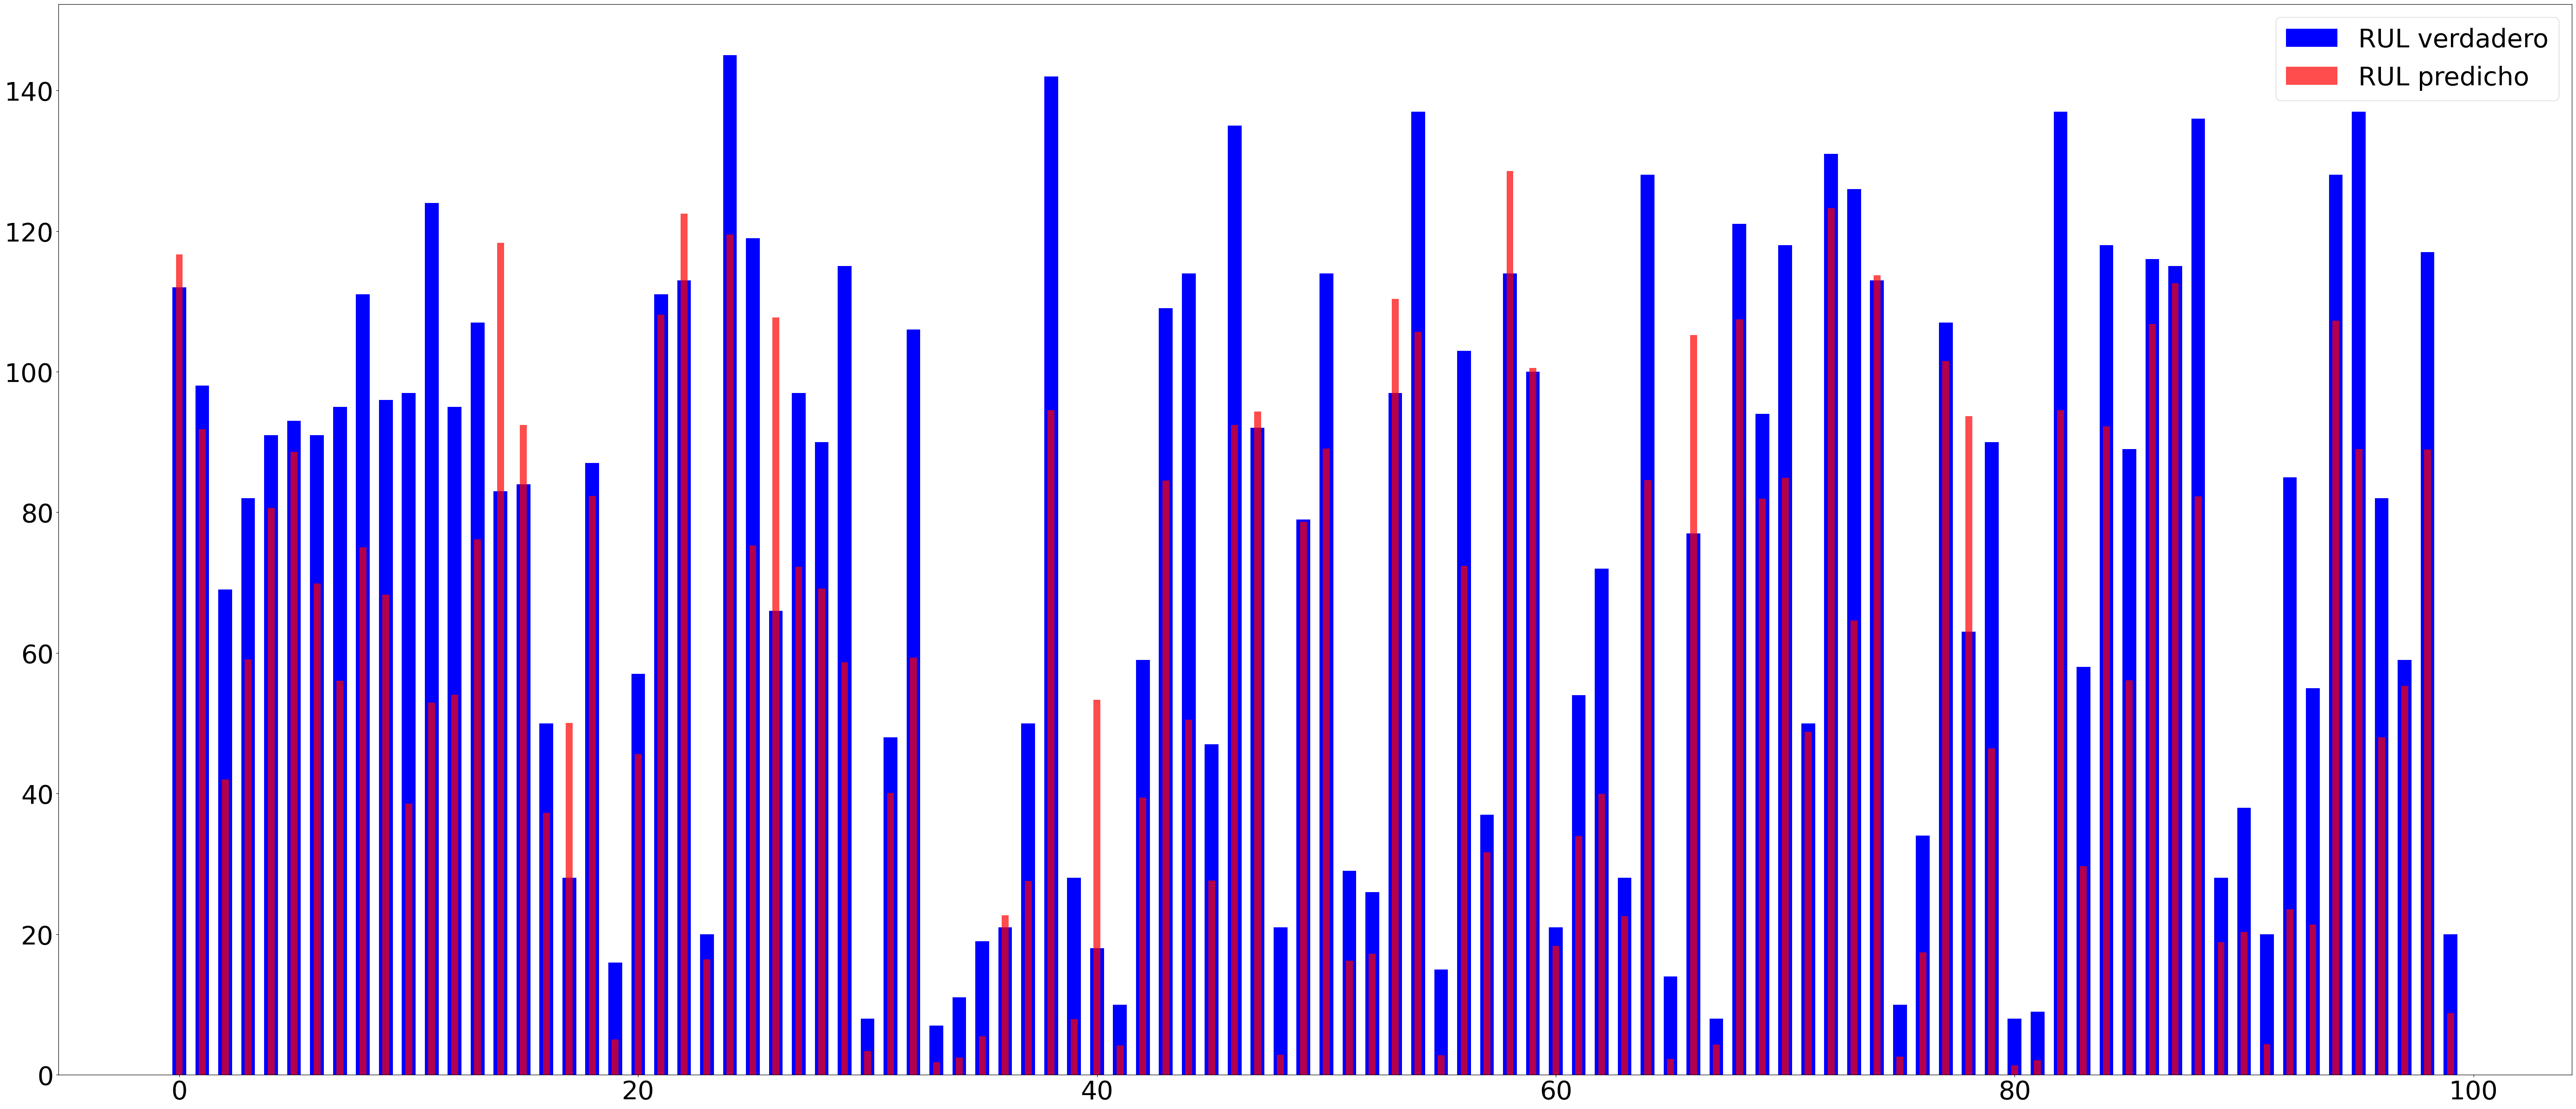

In [46]:
plot_predActual(y_valid, y_rf_valid)

---

### Sin data inútil y con valores históricos
Ahora vamos a probar agregando data histórica me diante un "rolling mean", que es un valor promedio tomado de cada 10 ciclos.

In [47]:
df = train.copy()

for x in X_train_2.columns:
    df[x+'_rm']=0

df.columns

Index(['unit_number', 'time_cycles', 'setting_1', 'setting_2', 'setting_3',
       's_1', 's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10',
       's_11', 's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19',
       's_20', 's_21', 'RUL', 's_2_rm', 's_3_rm', 's_4_rm', 's_7_rm', 's_8_rm',
       's_9_rm', 's_11_rm', 's_12_rm', 's_13_rm', 's_14_rm', 's_15_rm',
       's_17_rm', 's_20_rm', 's_21_rm'],
      dtype='object')

In [48]:
drop_labels2=['s_1', 's_5','s_6','s_10',  's_16', 's_18', 's_19']

df = df.drop(columns=setting_names+drop_labels2+['RUL'], axis=1)

X_valid_3 = valid.drop(columns=index_names+setting_names+drop_labels2, axis=1)

In [49]:
def update_rolling_mean(data, mask):
    for x, group in mask.groupby("unit_number"):
        for x in X_train_2.columns:
            data.loc[group.index[10:], x+"_rm"] = data.loc[group.index, x].rolling(10).mean()[10:]
            data.loc[group.index[:10], x+"_rm"] = data.loc[group.index[:10], x]

update_rolling_mean(df, df)
update_rolling_mean(X_valid_3, valid)

X_valid_3=X_valid_3.fillna(0)

# Para solucionar problema de la última línea
df.iloc[-1,-14:]=df.iloc[-2,-14:]
X_valid_3.iloc[-1,-14:]=X_valid_3.iloc[-2,-14:]

In [50]:
train_tm = df

train_tm = train_tm.drop(columns=index_names, axis=1)

In [51]:
train_tm

,s_2,s_3,s_4,s_7,s_8,s_9,s_11,s_12,s_13,s_14,...,s_8_rm,s_9_rm,s_11_rm,s_12_rm,s_13_rm,s_14_rm,s_15_rm,s_17_rm,s_20_rm,s_21_rm
0,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,...,2388.060,9046.190,47.470,521.660,2388.020,8138.620,8.41950,392.0,39.060,23.41900
1,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,...,2388.040,9044.070,47.490,522.280,2388.070,8131.490,8.43180,392.0,39.000,23.42360
2,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,...,2388.080,9052.940,47.270,522.420,2388.030,8133.230,8.41780,390.0,38.950,23.34420
3,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,...,2388.110,9049.480,47.130,522.860,2388.080,8133.830,8.36820,392.0,38.880,23.37390
4,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,...,2388.060,9055.150,47.280,522.190,2388.040,8133.800,8.42940,393.0,38.900,23.40440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,...,2388.224,9066.903,48.116,519.840,2388.237,8141.170,8.51031,396.0,38.453,23.09254
20627,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,...,2388.225,9066.820,48.116,519.793,2388.237,8140.771,8.51083,395.9,38.416,23.08540
20628,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,...,2388.223,9066.642,48.096,519.796,2388.240,8140.882,8.51915,396.2,38.424,23.07321
20629,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,...,2388.230,9067.045,48.136,519.813,2388.239,8140.833,8.52434,396.0,38.388,23.07370


In [52]:
X_train_tm, X_test_tm, y_train_tm, y_test_tm=train_test_split(train_tm,train['RUL'].clip(upper=195), test_size=0.35, random_state=42)
#X_train_tm, X_test_tm, y_train_tm, y_test_tm=train_test_split(train_tm,train['RUL'], test_size=0.35, random_state=42)
X_train_tm_s=scaler.fit_transform(X_train_tm)
X_test_tm_s=scaler.fit_transform(X_test_tm)
X_val3=pd.concat([valid['unit_number'],X_valid_3],axis=1)
X_valid3 = X_val3.groupby('unit_number').last().reset_index().drop(columns=['unit_number'])
X_valid_s=scaler.fit_transform(X_valid3)

### Regresión Lineal

In [53]:
lr=Linear_Regression()
lr.fit(X_train_tm_s, y_train_tm)

y_lr_train = lr.predict(X_train_tm_s)
evaluate(y_train_tm,y_lr_train, label='train')

y_lr_test = lr.predict(X_test_tm_s)
evaluate(y_test_tm, y_lr_test, label='test')

y_lr_valid = lr.predict(X_valid_s)
evaluate(y_valid, y_lr_valid, label='valid')

train set RMSE:40.529140113375824, R2:0.5544980153774888
test set RMSE:40.0989396737232, R2:0.5545324354987834
valid set RMSE:38.39141884713507, R2:0.14648967061777074


### SVR

In [54]:
regressor.fit(X_train_tm_s, y_train_tm)

y_svr_train = regressor.predict(X_train_tm_s)
evaluate(y_train_tm,y_svr_train, label='train')

y_svr_test = regressor.predict(X_test_tm_s)
evaluate(y_test_tm, y_svr_test, label='test')

y_svr_valid = regressor.predict(X_valid_s)
evaluate(y_valid, y_svr_valid, label='valid')

train set RMSE:32.48452364307428, R2:0.7138011601047023
test set RMSE:33.82872041899003, R2:0.6829546036019843
valid set RMSE:26.590317383722343, R2:0.5905626119267564


### Random forest

In [55]:
rf = RandomForestRegressor(max_features="sqrt", random_state=42)
rf.fit(X_train_tm_s, y_train_tm)

y_rf_train = rf.predict(X_train_tm_s)
evaluate(y_train_tm,y_rf_train, label='train')

y_rf_test = rf.predict(X_test_tm_s)
evaluate(y_test_tm, y_rf_test, label='test')

y_rf_valid = rf.predict(X_valid_s)
evaluate(y_valid, y_rf_valid, label='valid')

train set RMSE:9.787255139684294, R2:0.9740201473464815
test set RMSE:29.95828541820653, R2:0.7513524307207359
valid set RMSE:37.19248063789238, R2:0.19896637476274992


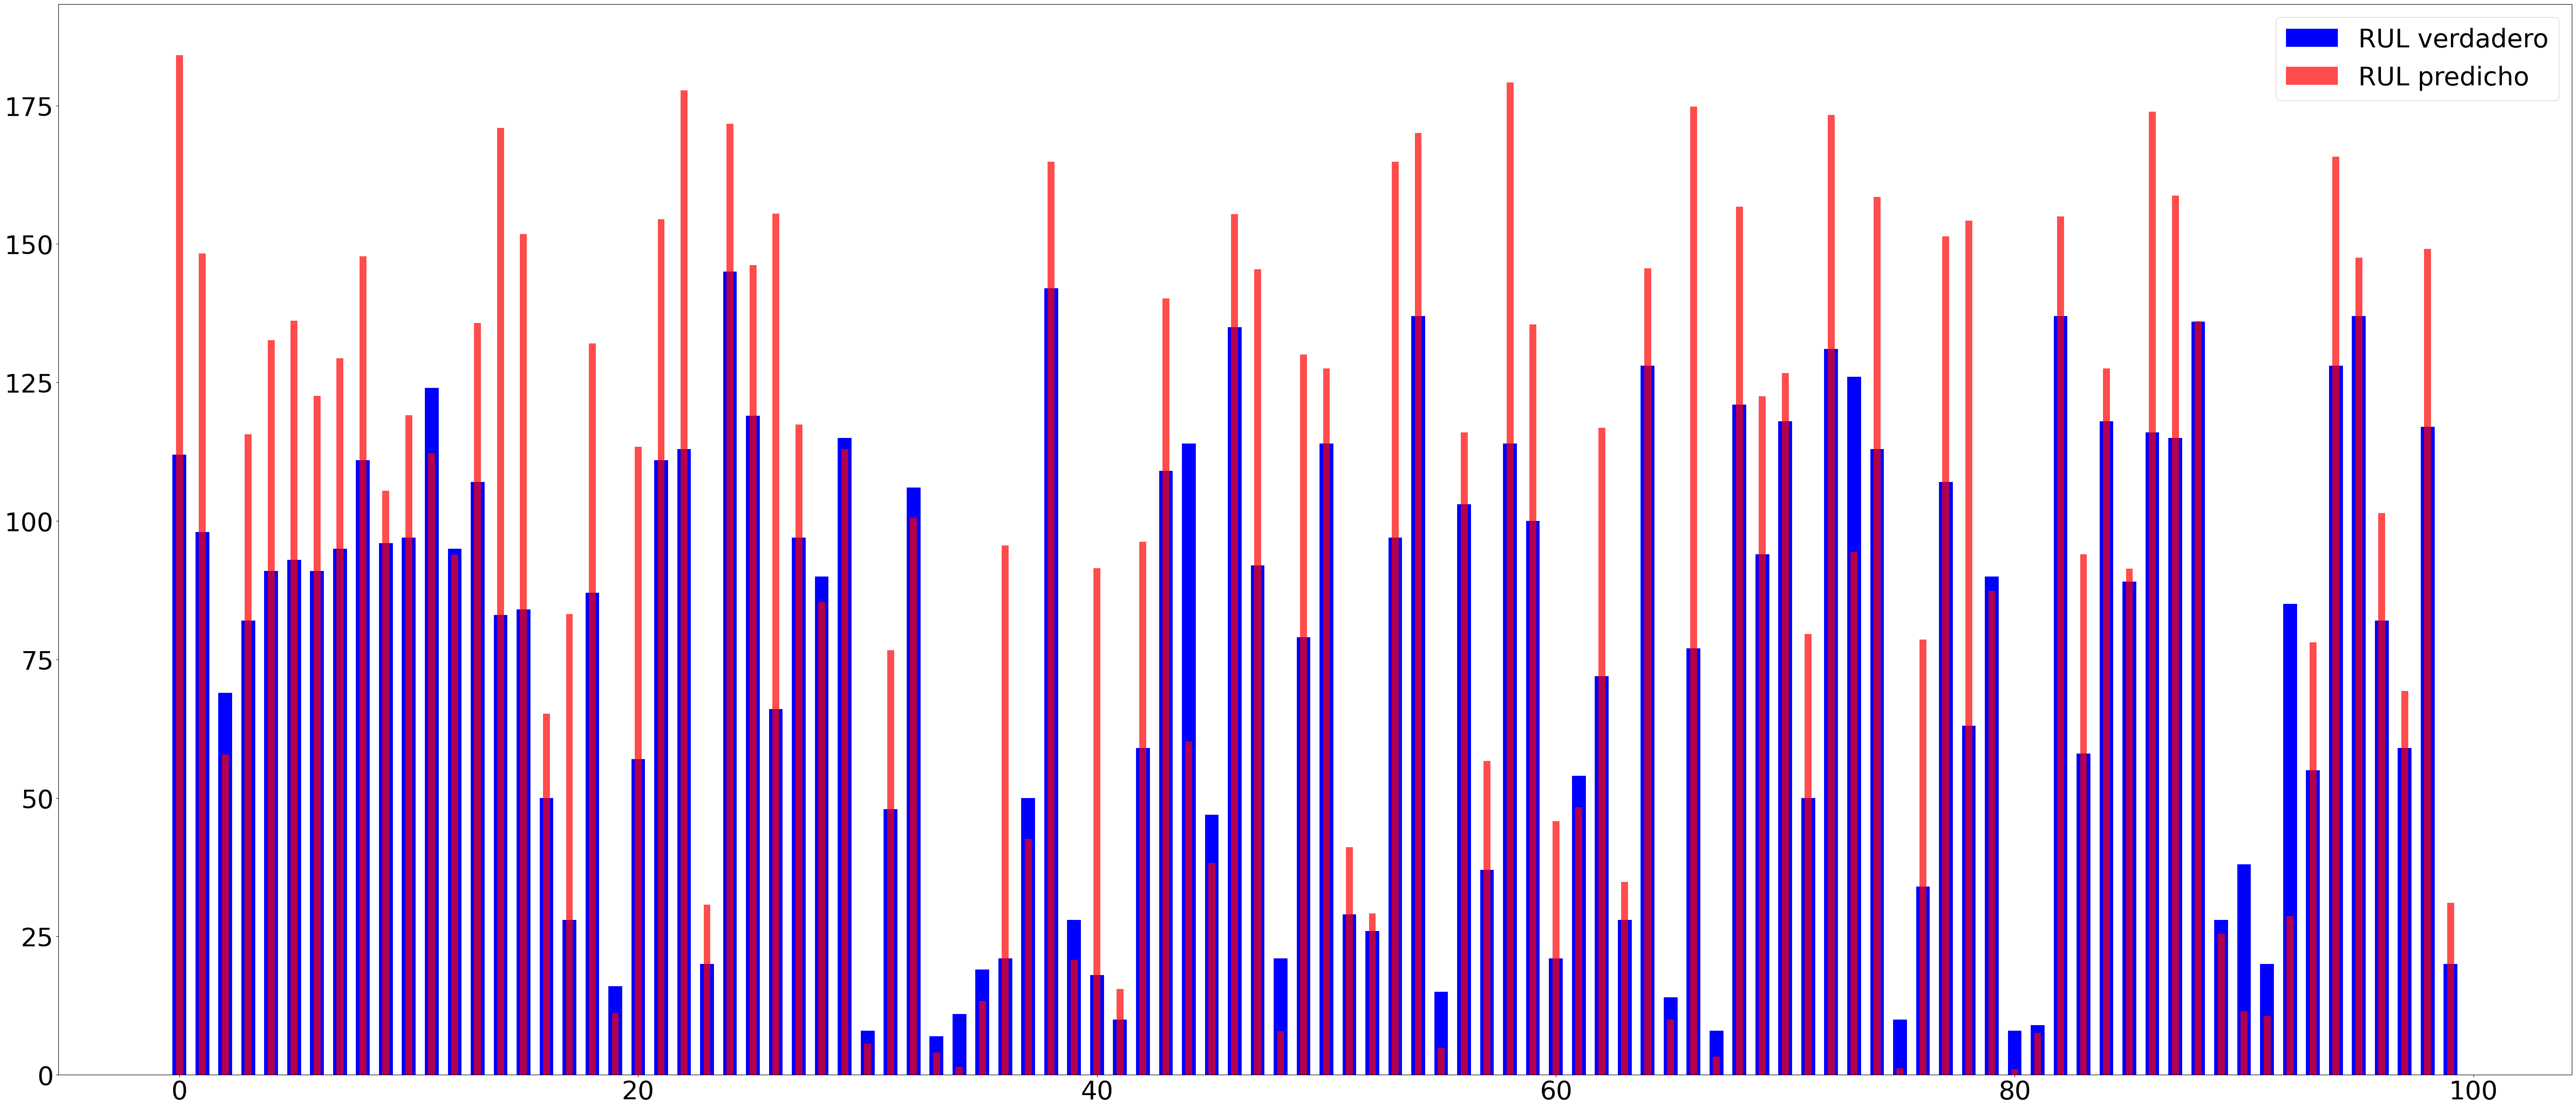

In [56]:
plot_predActual(y_valid, y_rf_valid)

Importancia de las variables

<BarContainer object of 28 artists>

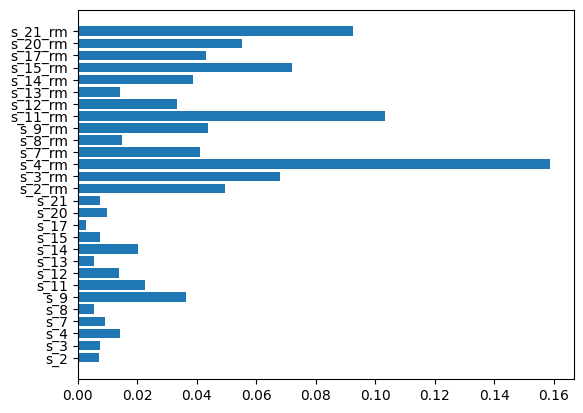

In [57]:
rf.fit(X_train_tm_s, y_train_tm)
plt.barh(train_tm.columns, rf.feature_importances_)